## General ARIMA/SARIMA/SARIMAX Model

In [13]:
import pandas as pd
from dateutil.parser import *
import datetime as dt
import time
from dateutil import tz
import pytz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from sklearn.metrics import mean_squared_error

In [3]:
#getting the pkl file name of certain pair
def get_his_data_filename(pair, granularity,time_from = None, time_to = None):
    
    if time_from:
        
        return f"./datasets/{pair}_{granularity}_{time_from}_{time_to}.pkl"
        
    else:
        return f"./datasets/{pair}_{granularity}.pkl"

# change timezone to sg
def astimezone(row):
    return row.astimezone(pytz.timezone('Singapore'))

#convert any date string with dateutil and then put a tz at the back
def get_utc_dt_from_string(date_str):
    d = parse(date_str)
    return d.replace(tzinfo=dt.timezone.utc)

In [4]:
# Loading daily gold prices

ts_df = pd.read_pickle('./datasets/XAU_USD_D_010115_300322.pkl')

# as oanda times are in utc string format, we will have to parse it back to sgt format

ts_df['time'] = ts_df['time'].apply(get_utc_dt_from_string)

# changing timezone to sgt
ts_df['time'] = ts_df['time'].apply(astimezone)

ts_df = ts_df.set_index('time')

ts_df

,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
time,,,,,,,,,,,,,
2015-01-02 06:00:00+08:00,31239,1184.161,1195.137,1167.622,1188.772,1183.371,1194.854,1166.527,1187.638,1184.951,1195.424,1168.563,1189.907
2015-01-05 06:00:00+08:00,69800,1188.893,1207.662,1178.311,1204.693,1188.043,1207.484,1177.321,1204.170,1189.743,1207.849,1178.629,1205.216
2015-01-06 06:00:00+08:00,128130,1204.438,1223.280,1201.790,1218.510,1203.915,1223.068,1200.753,1218.245,1204.961,1223.497,1201.959,1218.774
2015-01-07 06:00:00+08:00,104292,1218.881,1219.448,1208.954,1211.577,1218.081,1218.660,1207.833,1211.020,1219.681,1220.696,1209.268,1212.134
2015-01-08 06:00:00+08:00,78202,1211.134,1216.866,1204.504,1208.949,1210.334,1216.472,1204.054,1208.709,1211.934,1217.261,1204.954,1209.189
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24 05:00:00+08:00,474861,1944.470,1966.206,1937.505,1957.880,1944.324,1966.054,1937.335,1957.545,1944.616,1966.358,1937.652,1958.215
2022-03-25 05:00:00+08:00,427259,1958.680,1964.380,1943.195,1958.020,1958.345,1964.255,1942.988,1957.662,1959.015,1964.505,1943.397,1958.378
2022-03-28 05:00:00+08:00,598864,1956.370,1958.470,1917.130,1922.800,1956.068,1958.301,1916.920,1922.660,1956.672,1958.645,1917.285,1922.940


Text(0.5, 1.0, 'Gold Price By Day')

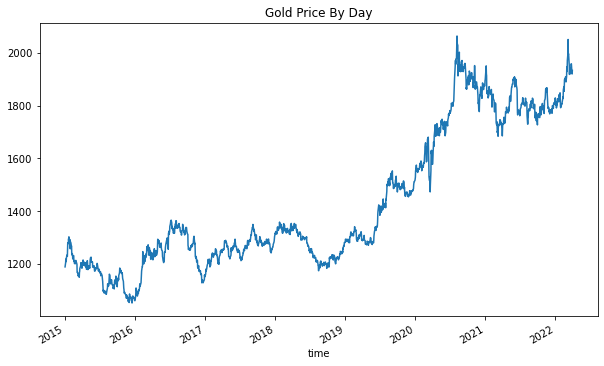

In [5]:
#Plotting daily gold prices
plt.figure(figsize = (10,6))


ts_df['mid_c'].plot()

plt.title('Gold Price By Day')

We can see that the prices are clearly not stationary. Since sarimax models assume stationarity, we will have to difference it.

<AxesSubplot:title={'center':'Gold Returns'}, xlabel='time'>

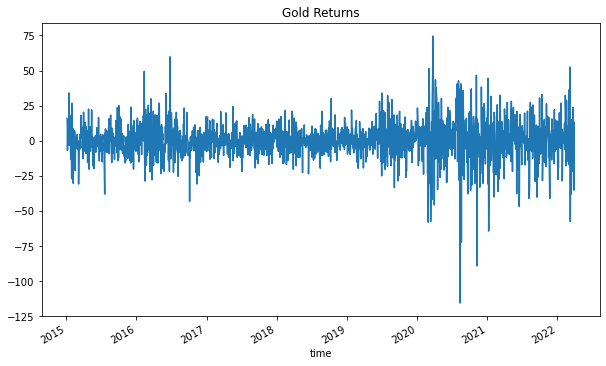

In [6]:
#Trying differencing once to make it stationary

plt.figure(figsize = (10,6))

plt.title('Gold Returns')

ts_df['mid_c'].diff().plot()

It seems like the chart is now stationary after differencing it once. Let us double check this.

In [7]:
#diff terms required
ndiffs(ts_df['mid_c'])

1

In [8]:
def interpret_df_test(dftest):
    df_output = pd.Series(dftest[0:2],index = ['Test Statistic','p-value'])
    return df_output

interpret_df_test(adfuller(ts_df['mid_c'].diff().dropna()))

Test Statistic   -21.266229
p-value            0.000000
dtype: float64

Since the p-value for the 1st difference is small, we have reason to believe that gold returns are stationary.

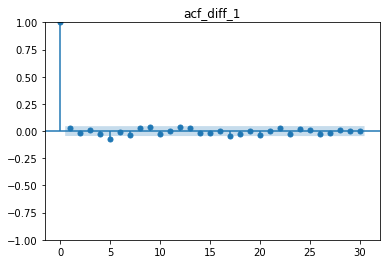

In [9]:
#plotting acf
plot_acf(ts_df['mid_c'].diff().dropna(),lags = 30)

plt.title('acf_diff_1')

plt.show()

From the acf charts, we predict that a possible moving average could be 5 as lag 5 has a significant drop.

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


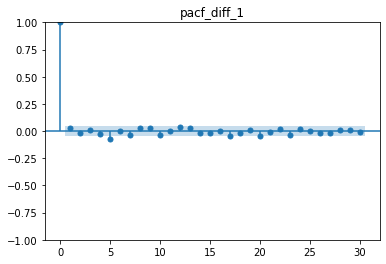

In [10]:
#plotting pacf

plot_pacf(ts_df['mid_c'].diff().dropna(),lags=30)

plt.title('pacf_diff_1')

plt.show()

From the pacf charts, we predict that a possible auto regressive term could be 5 as lag 5 has a significant drop.

In [19]:
# Let us try an auto arima model, which uses AIC to finish the best parameters

auto_arima_model = auto_arima(ts_df['mid_c'],start_p = 1, start_q = 1, max_p = 5, max_q = 5, d=1,
                            supresss_warnings = True,n_jobs = -1, trace = True) 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15080.780, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15079.258, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15079.398, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15079.329, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15078.974, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.791 seconds


The auto arima model is suggesting that the price movement is a random walk model. It is a series with infinitely slow mean reversion.

In [16]:
# Fitting in ARIMA Model
display(len(ts_df)*0.9)

train = ts_df['mid_c'][:1700]
test = ts_df['mid_c'][1700:]

1701.9

In [17]:
auto_arima_model.fit(train)

future_forecast = auto_arima_model.predict(n_periods=191)

arima_pred_df = pd.DataFrame(test.values,columns = ['actual'],index = test.index)
arima_pred_df['pred'] = future_forecast

score = np.sqrt(mean_squared_error(arima_pred_df['pred'],arima_pred_df['actual']))

score

66.0728466001592

Text(0.5, 1.0, 'Auto Arima (0,1,0)')

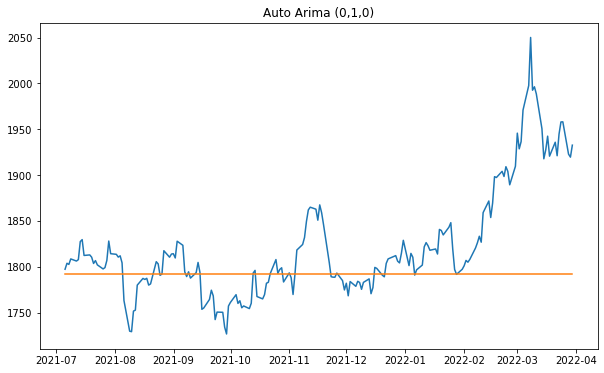

In [20]:
plt.figure(figsize=(10,6))
plt.plot(arima_pred_df)

plt.title('Auto Arima (0,1,0)')

We see that our auto arima model merely predicts a straight line. This provides us with a root mean squared error of 66. Let us see if we can do better.

In [21]:
auto_sarima_model = auto_arima(ts_df['mid_c'], start_p=1, start_q=1,
                           max_p=5, max_q=5, m=5,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True, 
                           suppress_warnings=True, n_jobs=-1)

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/pmdarima/arima/_validation.py:77: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  'Falling back to stepwise parameter search.' % n_jobs)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=16476.335, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=15883.652, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=0.77 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=16474.493, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=15631.697, Time=0.35 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=2.55 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=1.17 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=15631.409, Time=0.14 sec
 ARIMA(0,1,0)(1,1,0)[5]             : AIC=15882.596, Time=0.06 sec
 ARIMA(0,1,0)(2,1,1)[5]             : AIC=inf, Time=1.46 sec
 ARIMA(0,1,0)(1,1,1)[5]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(2,1,0)[5]             : AIC=15631.616, Time=0.31 sec
 ARIMA(1,1,1)(2,1,0)[5]             : AIC=15632.922, Time=0.71 sec
 ARIMA(0,1,0)(2,1,0)[5] intercept   : AIC=15633.385, Ti

In [22]:
auto_sarima_model.fit(train)

future_forecast = auto_sarima_model.predict(n_periods=191)

sarima_pred_df = pd.DataFrame(test.values,columns = ['actual'],index = test.index)
sarima_pred_df['pred'] = future_forecast

score = np.sqrt(mean_squared_error(sarima_pred_df['pred'],sarima_pred_df['actual']))

score

274.1839517708194

Text(0.5, 1.0, 'Auto Sarima (0,1,0) x (2,1,0,5)')

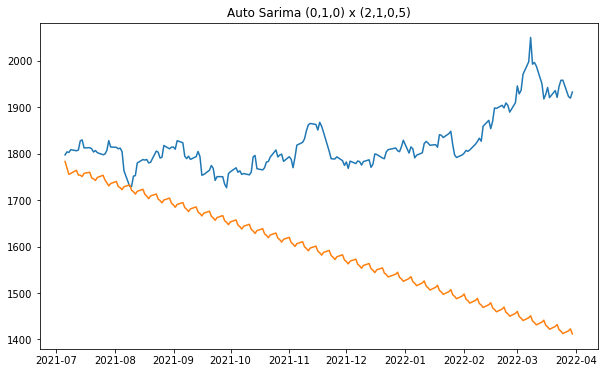

In [23]:
plt.figure(figsize=(10,6))
plt.plot(sarima_pred_df)

plt.title('Auto Sarima (0,1,0) x (2,1,0,5)')

Our auto sarima model does much worse than our arima model, with a root mean squared error of 274. Let us try manual grid searching, with root mean squared error as the main metric.

In [187]:
#gridsearch arima model
final_rmse = 10000000

final_p= 0
final_d= 0
final_q= 0
final_P= 0
final_D= 0
final_Q= 0
final_S= 0

d=1
P=0
D=0
Q=0
S=0

for p in range(0,6):
    for q in range(0,6):
        #for P in range(0,3):
            #for Q in range(0,3):
                        #try:
                            arima = SARIMAX(endog = train.values,
                                             order = (p,d,q),
                                             seasonal_order = (P,D,Q,S),
                                             
                            )

                            arima_model = arima.fit()

                            preds = arima_model.forecast(191)
                            
                            rmse = np.sqrt(mean_squared_error(test,preds))

                            print(f'The RMSE for ({p}, {d}, {q})x({P},{D},{Q},{S}) is: {rmse}')

                            if rmse < final_rmse:

                                final_rmse = rmse

                                final_p= p
                                final_d= d
                                final_q= q
                                final_P= P
                                final_D= D
                                final_Q= Q
                                final_S= S
                                
                                arima_final_model = arima_model
                            
                        #except:
                             #pass

print(f'Our model that minimizes RMSE on the training data is the ARIMA({final_p}, {final_d}, {final_q})x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an RMSE of {rmse}.')

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96163D+00    |proj g|=  4.61117D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   5.310D-07   3.962D+00
  F =   3.9616254598296448     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (0, 1, 0)x(0,0,0,0) is: 66.0728466001592
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


The RMSE for (0, 1, 2)x(0,0,0,0) is: 65.9714673000494
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96120D+00    |proj g|=  2.27655D-03

At iterate    5    f=  3.96119D+00    |proj g|=  4.87824D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   6.010D-07   3.961D+00
  F =   3.9611907495952785     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (0, 1, 3)x(0,0,0,0) is: 65.88021990763224
RUNNING THE L-BFGS-B CO

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.96052D+00    |proj g|=  1.54196D-04

At iterate   10    f=  3.96052D+00    |proj g|=  8.02012D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   8.020D-06   3.961D+00
  F =   3.9605217090579092     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (0, 1, 4)x(0,0,0,0) is: 66.41047758907477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95725D+00    |proj g|=  9.54559D-03


 This problem is unconstrained.



At iterate    5    f=  3.95718D+00    |proj g|=  7.73399D-04

At iterate   10    f=  3.95717D+00    |proj g|=  3.10088D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   1.587D-06   3.957D+00
  F =   3.9571719063821162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (0, 1, 5)x(0,0,0,0) is: 66.7719627068306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96125D+00    |proj g|=  2.58656D-05

           * * 

 This problem is unconstrained.
 This problem is unconstrained.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


The RMSE for (1, 1, 1)x(0,0,0,0) is: 65.97792660402527
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96163D+00    |proj g|=  2.73994D-02

At iterate    5    f=  3.96123D+00    |proj g|=  7.20690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     11      1     0     0   4.144D-05   3.961D+00
  F =   3.9612273967040310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (1, 1, 2)x(0,0,0,0) is: 65.96919966982082
RUNNING THE L-BFGS-B C

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  3.96123D+00    |proj g|=  4.32415D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   6.784D-05   3.961D+00
  F =   3.9612280669110103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (1, 1, 3)x(0,0,0,0) is: 65.98338239001184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95999D+00    |proj g|=  6.21253D-03

At iterate    5    f=  3.95962D+00    |proj g|=  1.66089D-02

At iterate   1

 This problem is unconstrained.


At iterate    5    f=  3.95700D+00    |proj g|=  1.58646D-03

At iterate   10    f=  3.95698D+00    |proj g|=  2.80763D-04

At iterate   15    f=  3.95696D+00    |proj g|=  2.73467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     19     22      1     0     0   2.290D-05   3.957D+00
  F =   3.9569546113108856     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (1, 1, 5)x(0,0,0,0) is: 66.72604410760297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  3.96086D+00    |proj g|=  1.40612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   1.634D-05   3.961D+00
  F =   3.9608601423522742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (2, 1, 1)x(0,0,0,0) is: 66.11528847193999
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96163D+00    |proj g|=  2.74228D-02

At iterate    5    f=  3.96123D+00    |proj g|=  1.19161D-03

At iterate   1

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96135D+00    |proj g|=  1.43412D-02

At iterate    5    f=  3.96121D+00    |proj g|=  1.13980D-03

At iterate   10    f=  3.96110D+00    |proj g|=  8.27239D-03

At iterate   15    f=  3.96099D+00    |proj g|=  3.45493D-03

At iterate   20    f=  3.96075D+00    |proj g|=  1.53982D-03

At iterate   25    f=  3.96073D+00    |proj g|=  4.39331D-04

At iterate   30    f=  3.96071D+00    |proj g|=  1.95163D-03

At iterate   35    f=  3.96053D+00    |proj g|=  2.03442D-03

At iterate   40    f=  3.96045D+00    |proj g|=  7.75708D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate    5    f=  3.95902D+00    |proj g|=  1.88141D-02

At iterate   10    f=  3.95833D+00    |proj g|=  1.95181D-03

At iterate   15    f=  3.95811D+00    |proj g|=  5.00787D-03

At iterate   20    f=  3.95806D+00    |proj g|=  4.55680D-04

At iterate   25    f=  3.95805D+00    |proj g|=  7.75558D-04

At iterate   30    f=  3.95805D+00    |proj g|=  2.73013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     38      1     0     0   2.422D-05   3.958D+00
  F =   3.9580525838881786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (2, 1, 4)x(0,0,0,0) is: 66.90974614328

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95687D+00    |proj g|=  1.07378D-02

At iterate    5    f=  3.95680D+00    |proj g|=  1.14717D-03

At iterate   10    f=  3.95678D+00    |proj g|=  1.00965D-03

At iterate   15    f=  3.95678D+00    |proj g|=  7.70337D-04

At iterate   20    f=  3.95678D+00    |proj g|=  1.11050D-04

At iterate   25    f=  3.95678D+00    |proj g|=  3.32691D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     33      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.96121D+00    |proj g|=  3.88069D-04

At iterate   10    f=  3.96120D+00    |proj g|=  1.76582D-03

At iterate   15    f=  3.96118D+00    |proj g|=  1.24059D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     36      1     0     0   4.801D-05   3.961D+00
  F =   3.9611806423379226     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (3, 1, 1)x(0,0,0,0) is: 65.90263044509207
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  3.96090D+00    |proj g|=  8.61367D-03

At iterate   20    f=  3.96048D+00    |proj g|=  1.40699D-03

At iterate   25    f=  3.96046D+00    |proj g|=  2.23373D-03

At iterate   30    f=  3.95954D+00    |proj g|=  4.05822D-03

At iterate   35    f=  3.95927D+00    |proj g|=  1.10888D-02

At iterate   40    f=  3.95878D+00    |proj g|=  7.43156D-03

At iterate   45    f=  3.95816D+00    |proj g|=  4.12082D-02

At iterate   50    f=  3.95709D+00    |proj g|=  9.41506D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     66      1     0     0   9.415D-02   3.957D+00
  F =   3.95709105992

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.



At iterate    5    f=  3.96047D+00    |proj g|=  2.85813D-03

At iterate   10    f=  3.95977D+00    |proj g|=  1.80388D-02

At iterate   15    f=  3.95890D+00    |proj g|=  2.27626D-02

At iterate   20    f=  3.95834D+00    |proj g|=  2.39451D-03

At iterate   25    f=  3.95824D+00    |proj g|=  9.65410D-04

At iterate   30    f=  3.95824D+00    |proj g|=  1.14460D-03

At iterate   35    f=  3.95823D+00    |proj g|=  3.21537D-04

At iterate   40    f=  3.95823D+00    |proj g|=  8.24484D-04

At iterate   45    f=  3.95821D+00    |proj g|=  1.82171D-03


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.



At iterate   50    f=  3.95818D+00    |proj g|=  6.34610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59      1     0     0   6.346D-04   3.958D+00
  F =   3.9581842581148958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The RMSE for (3, 1, 3)x(0,0,0,0) is: 65.61957662627562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96002D+00    |proj g|=  5.23629D-03

At iterate    5    f=  3.95991D+00    |proj g|=  6.97608D-03

At iterate   1

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.


The RMSE for (3, 1, 4)x(0,0,0,0) is: 66.79166456938461
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95692D+00    |proj g|=  9.83115D-03

At iterate    5    f=  3.95685D+00    |proj g|=  1.21813D-03

At iterate   10    f=  3.95679D+00    |proj g|=  2.19164D-03

At iterate   15    f=  3.95678D+00    |proj g|=  9.56599D-04

At iterate   20    f=  3.95678D+00    |proj g|=  8.08356D-05

At iterate   25    f=  3.95677D+00    |proj g|=  2.20826D-03

At iterate   30    f=  3.95675D+00    |proj g|=  2.21127D-04

At iterate   35    f=  3.95675D+00    |proj g|=  2.79460D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.95955D+00    |proj g|=  2.54570D-02

At iterate   10    f=  3.95889D+00    |proj g|=  2.07643D-03

At iterate   15    f=  3.95888D+00    |proj g|=  3.22947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   8.380D-06   3.959D+00
  F =   3.9588795830638488     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (4, 1, 1)x(0,0,0,0) is: 67.01300499885421
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   15    f=  3.95831D+00    |proj g|=  6.40233D-03

At iterate   20    f=  3.95806D+00    |proj g|=  7.69027D-04

At iterate   25    f=  3.95804D+00    |proj g|=  5.84705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   3.480D-05   3.958D+00
  F =   3.9580424191641028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The RMSE for (4, 1, 2)x(0,0,0,0) is: 66.86597393853829


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96035D+00    |proj g|=  2.08489D-02

At iterate    5    f=  3.96000D+00    |proj g|=  4.33018D-03

At iterate   10    f=  3.95898D+00    |proj g|=  5.80264D-03

At iterate   15    f=  3.95872D+00    |proj g|=  4.36755D-03

At iterate   20    f=  3.95834D+00    |proj g|=  5.63454D-03

At iterate   25    f=  3.95823D+00    |proj g|=  1.05454D-03

At iterate   30    f=  3.95817D+00    |proj g|=  3.66455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95961D+00    |proj g|=  3.65342D-02

At iterate    5    f=  3.95894D+00    |proj g|=  2.11003D-03

At iterate   10    f=  3.95811D+00    |proj g|=  9.56230D-03

At iterate   15    f=  3.95663D+00    |proj g|=  1.06333D-02

At iterate   20    f=  3.95638D+00    |proj g|=  3.14875D-03

At iterate   25    f=  3.95622D+00    |proj g|=  1.13545D-03

At iterate   30    f=  3.95616D+00    |proj g|=  9.97449D-03

At iterate   35    f=  3.95556D+00    |proj g|=  3.05553D-02

At iterate   40    f=  3.95513D+00    |proj g|=  2.59177D-02

At iterate   45    f=  3.95480D+00    |proj g|=  1.37195D-02

At iterate   50    f=  3.95469D+00    |proj g|=  5.18746D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95617D+00    |proj g|=  4.06298D-03

At iterate    5    f=  3.95615D+00    |proj g|=  1.09204D-03

At iterate   10    f=  3.95609D+00    |proj g|=  2.79742D-03

At iterate   15    f=  3.95608D+00    |proj g|=  1.68331D-03

At iterate   20    f=  3.95606D+00    |proj g|=  5.40167D-04

At iterate   25    f=  3.95605D+00    |proj g|=  2.50379D-03

At iterate   30    f=  3.95604D+00    |proj g|=  1.23639D-03

At iterate   35    f=  3.95603D+00    |proj g|=  1.73713D-04

At iterate   40    f=  3.95603D+00    |proj g|=  6.43887D-04

At iterate   45    f=  3.95603D+00    |proj g|=  6.91366D-04


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   50    f=  3.95603D+00    |proj g|=  2.59624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   2.596D-04   3.956D+00
  F =   3.9560274317875397     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The RMSE for (4, 1, 5)x(0,0,0,0) is: 66.7957081861703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95713D+00    |proj g|=  9.27351D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of 

 This problem is unconstrained.



At iterate    5    f=  3.95863D+00    |proj g|=  4.18601D-03

At iterate   10    f=  3.95759D+00    |proj g|=  2.00470D-02

At iterate   15    f=  3.95729D+00    |proj g|=  2.82074D-03

At iterate   20    f=  3.95697D+00    |proj g|=  1.09215D-02

At iterate   25    f=  3.95672D+00    |proj g|=  2.06475D-03

At iterate   30    f=  3.95661D+00    |proj g|=  1.95358D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     36      1     0     0   3.000D-06   3.957D+00
  F =   3.9566072293592547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The RMSE for (5, 1, 2)x(0,0,0,0) is: 66.93593980989

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   10    f=  3.95676D+00    |proj g|=  1.96390D-03

At iterate   15    f=  3.95673D+00    |proj g|=  3.49625D-03

At iterate   20    f=  3.95669D+00    |proj g|=  5.74324D-04

At iterate   25    f=  3.95665D+00    |proj g|=  4.51287D-03

At iterate   30    f=  3.95654D+00    |proj g|=  5.24033D-04

At iterate   35    f=  3.95654D+00    |proj g|=  1.92504D-04

At iterate   40    f=  3.95654D+00    |proj g|=  2.05100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     44     50      1     0     0   1.605D-05   3.957D+00
  F =   3.9565406510414345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  3.95611D+00    |proj g|=  3.67859D-03

At iterate   10    f=  3.95605D+00    |proj g|=  2.86427D-04

At iterate   15    f=  3.95605D+00    |proj g|=  1.57124D-03

At iterate   20    f=  3.95604D+00    |proj g|=  2.17426D-04

At iterate   25    f=  3.95603D+00    |proj g|=  2.27155D-03

At iterate   30    f=  3.95602D+00    |proj g|=  3.41441D-04

At iterate   35    f=  3.95602D+00    |proj g|=  3.20043D-04

At iterate   40    f=  3.95602D+00    |proj g|=  4.81564D-04

At iterate   45    f=  3.95602D+00    |proj g|=  3.01664D-04


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 This problem is unconstrained.



At iterate   50    f=  3.95602D+00    |proj g|=  1.22272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     54      1     0     0   1.223D-04   3.956D+00
  F =   3.9560182119311351     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
The RMSE for (5, 1, 4)x(0,0,0,0) is: 66.71994542197528
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.95618D+00    |proj g|=  5.10574D-03

At iterate    5    f=  3.95615D+00    |proj g|=  3.78347D-03

At iterate   1

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [188]:
arima_final_model.specification

{'seasonal_periods': 0,
 'measurement_error': False,
 'time_varying_regression': False,
 'simple_differencing': False,
 'enforce_stationarity': True,
 'enforce_invertibility': True,
 'hamilton_representation': False,
 'concentrate_scale': False,
 'trend_offset': 1,
 'order': (4, 1, 4),
 'seasonal_order': (0, 0, 0, 0),
 'k_diff': 1,
 'k_seasonal_diff': 0,
 'k_ar': 4,
 'k_ma': 4,
 'k_seasonal_ar': 0,
 'k_seasonal_ma': 0,
 'k_ar_params': 4,
 'k_ma_params': 4,
 'trend': None,
 'k_trend': 0,
 'k_exog': 0,
 'mle_regression': False,
 'state_regression': False}

64.78892992723956

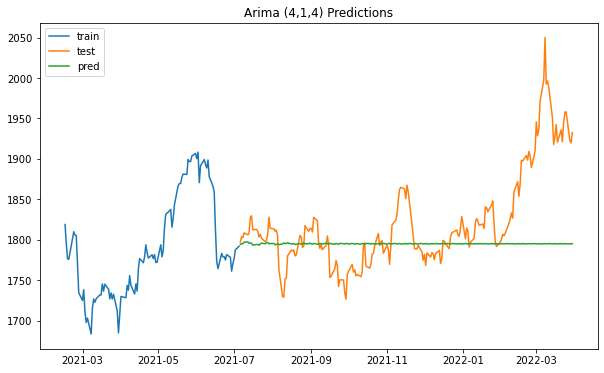

In [189]:
future_forecast = arima_final_model.forecast(191)

arima_pred_df = pd.DataFrame(test.values,columns = ['actual'],index = test.index)
arima_pred_df['pred'] = future_forecast


display(np.sqrt(mean_squared_error(arima_pred_df['pred'],arima_pred_df['actual'])))

plt.figure(figsize=(10,6))

plt.plot(train[-100:],label = 'train')
plt.plot(test, label = 'test')
plt.plot(arima_pred_df['pred'], label = 'pred')
plt.title('Arima (4,1,4) Predictions')
plt.legend()

Our arima model(4,1,4) does a little better with rmse 64 than our autoarima model. We can see that the auto arima model is able to predict a small rise at the start before going constant. Let us next try to gridsearch a sarima model.

In [20]:
# #gridsearch sarima model
# final_rmse = 10000000

# final_p= 0
# final_d= 0
# final_q= 0
# final_P= 0
# final_D= 0
# final_Q= 0
# final_S= 0

# d=1
# D=1
# S=5

# for p in range(0,6):
#     for q in range(0,6):
#         for P in range(0,6):
#             for Q in range(0,6):
#                         try:
#                             sarima = SARIMAX(endog = train.values,
#                                              order = (p,d,q),
#                                              seasonal_order = (P,D,Q,S),
                                             
#                             )

#                             sarima_model = sarima.fit()

#                             preds = sarima_model.forecast(191)
                            
#                             rmse = np.sqrt(mean_squared_error(test,preds))

#                             print(f'The RMSE for ({p}, {d}, {q})x({P},{D},{Q},{S}) is: {rmse}')

#                             if rmse < final_rmse:

#                                 final_rmse = rmse

#                                 final_p= p
#                                 final_d= d
#                                 final_q= q
#                                 final_P= P
#                                 final_D= D
#                                 final_Q= Q
#                                 final_S= S
                                
#                                 sarima_final_model = sarima_model
                            
#                         except:
#                              pass

# print(f'Our model that minimizes RMSE on the training data is the SARIMA({final_p}, {final_d}, {final_q})x({final_P},{final_D},{final_Q},{final_S}).')
# print(f'This model has an RMSE of {rmse}.')

# result:
# The RMSE for (5, 1, 5)x(0,1,0,5) is: 48.42713279190641
# Our model that minimizes RMSE on the training data is the SARIMA(5, 1, 5)x(0,1,0,5).
# This model has an RMSE of 48.42713279190641.

### Result:
The RMSE for (5, 1, 5)x(0,1,0,5) is: 48.42713279190641
Our model that minimizes RMSE on the training data is the SARIMA(5, 1, 5)x(0,1,0,5).
This model has an RMSE of 48.42713279190641.

In [190]:
sarima = SARIMAX(endog = train.values,
                                             order = (5,1,5),
                                             seasonal_order = (0,1,0,5),
                                             
                            )

sarima_final_model = sarima.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02666D+00    |proj g|=  1.05785D-01

At iterate    5    f=  4.00044D+00    |proj g|=  8.57341D-02

At iterate   10    f=  3.97579D+00    |proj g|=  1.35605D-01

At iterate   15    f=  3.96487D+00    |proj g|=  3.14543D-01

At iterate   20    f=  3.95998D+00    |proj g|=  7.99513D-02

At iterate   25    f=  3.95686D+00    |proj g|=  1.30701D-01

At iterate   30    f=  3.95519D+00    |proj g|=  4.88573D-02

At iterate   35    f=  3.95459D+00    |proj g|=  6.14482D-02

At iterate   40    f=  3.95441D+00    |proj g|=  2.55844D-03

At iterate   45    f=  3.95440D+00    |proj g|=  2.71670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

48.50255656163511

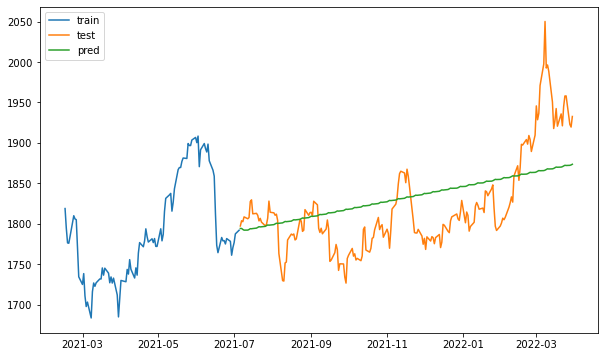

In [191]:
future_forecast = sarima_final_model.forecast(191)

sarima_pred_df = pd.DataFrame(test.values,columns = ['actual'],index = test.index)
sarima_pred_df['pred'] = future_forecast

display(np.sqrt(mean_squared_error(sarima_pred_df['pred'],sarima_pred_df['actual'])))

plt.figure(figsize=(10,6))

plt.plot(train[-100:],label = 'train')
plt.plot(test, label = 'test')
plt.plot(sarima_pred_df['pred'], label = 'pred')
plt.legend()



We can see that our sarima model (5,1,5) x (0,1,0,5) does much better than our arima model, where it is able to predict the general trend of gold with a rmse of 48. We will now explore using a sarimax model, where we will fit in some exogenuous variables.

In [202]:
# Loading and parsing silver candles

ts_df_sil = pd.read_pickle('./datasets/XAG_USD_D_010115_300322.pkl')

ts_df_sil['time'] = ts_df_sil['time'].apply(get_utc_dt_from_string)

ts_df_sil['time'] = ts_df_sil['time'].apply(astimezone)

ts_df_sil = ts_df_sil.set_index('time')

new_index = set(ts_df.index).intersection(set(ts_df_sil.index))

ts_df = ts_df.loc[new_index].sort_index()
ts_df_sil = ts_df_sil.loc[new_index].sort_index()

ts_df_sil

,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
time,,,,,,,,,,,,,
2015-01-02 06:00:00+08:00,9606,15.73792,16.07304,15.54160,15.76376,15.69792,16.05816,15.51100,15.74251,15.77792,16.08955,15.55410,15.78500
2015-01-05 06:00:00+08:00,21820,15.80194,16.27296,15.65106,16.18569,15.76194,16.25770,15.62750,16.15293,15.84194,16.28979,15.67327,16.21845
2015-01-06 06:00:00+08:00,24917,16.20033,16.72530,16.12058,16.53597,16.16757,16.69604,16.10481,16.51178,16.23309,16.75791,16.13566,16.56016
2015-01-07 06:00:00+08:00,22613,16.53174,16.65668,16.30235,16.53034,16.49174,16.63977,16.28985,16.51138,16.57174,16.67621,16.31485,16.54931
2015-01-08 06:00:00+08:00,15618,16.54764,16.66011,16.30540,16.36130,16.50764,16.64650,16.29090,16.34571,16.58764,16.67486,16.31863,16.37688
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-24 05:00:00+08:00,86007,25.12745,25.85150,24.97285,25.54050,25.11995,25.84400,24.96535,25.52700,25.13495,25.85975,24.98035,25.55400
2022-03-25 05:00:00+08:00,70978,25.55200,25.72450,25.26100,25.52800,25.54450,25.71700,25.25350,25.52050,25.55950,25.73200,25.26850,25.53550
2022-03-28 05:00:00+08:00,84635,25.56250,25.58735,24.79900,24.86900,25.55000,25.57985,24.79150,24.86069,25.57500,25.59615,24.80650,24.87731


[Text(0.5, 1.0, 'Heatmap of Change in Features with Change in Price')]

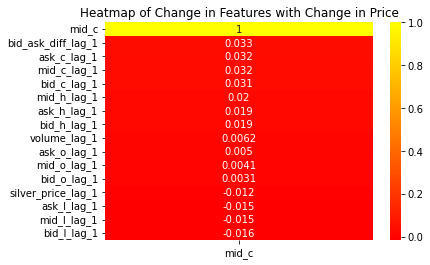

In [203]:
ts_df_heatmap = ts_df.copy()

ts_df_heatmap['silver_price'] = ts_df_sil['mid_c']

# creating exo for previous bid ask range

ts_df_heatmap['bid_ask_diff'] = ts_df['ask_h']-ts_df['bid_l']

# taking the differenced variables to observe how changes will impact price

ts_df_heatmap = ts_df_heatmap.diff().dropna()

lag_1_cols = ['mid_c']

# creating cols to lag variables

for col in ts_df_heatmap.columns:
     new_col = col + '_lag_1'
     ts_df_heatmap[new_col] = ts_df_heatmap[col].shift(1)
     lag_1_cols.append(new_col)
        
ts_df_heatmap = ts_df_heatmap[lag_1_cols].dropna()
ts_df_heatmap

# plotting out heatmap
sns.heatmap(ts_df_heatmap.corr()[['mid_c']].sort_values('mid_c',ascending=False),
            annot=True,cmap = 'autumn').set(title = 'Heatmap of Change in Features with Change in Price')

We can see that none of the lag 1 differenced variables is a good predictor of gold price.

In [204]:
# creating some rolling variables as exo variables

ts_df['mid_c_roll_5_lag_1'] = ts_df['mid_c'].shift(1).rolling(5).mean()
ts_df['mid_c_roll_10_lag_1'] = ts_df['mid_c'].shift(1).rolling(10).mean()
ts_df['mid_c_roll_20_lag_1'] = ts_df['mid_c'].shift(1).rolling(20).mean()
ts_df = ts_df.dropna()

In [206]:
ts_df_sil_lag1 = ts_df_sil['mid_c'].shift(1)
ts_df_sil_lag1 = ts_df_sil_lag1.loc[ts_df.index]

In [208]:
# creating test and train for sarimax with exo silver
display(0.9*len(ts_df))

ts_df_train = ts_df['mid_c'][:1678]
ts_df_test = ts_df['mid_c'][1678:]

ts_df_sil_lag1_train = ts_df_sil_lag1[:1678]
ts_df_sil_lag1_test = ts_df_sil_lag1[1678:]

rolling_list = ['mid_c_roll_5_lag_1','mid_c_roll_10_lag_1','mid_c_roll_20_lag_1']

rolling_train = ts_df[rolling_list][:1678]
rolling_test = ts_df[rolling_list][1678:]

1676.7

In [209]:
#grid searching sarimax with (5,1,5)

sarimax = SARIMAX(endog = ts_df_train,
                                             order = (5,1,5),
                                             seasonal_order = (0,1,0,5),
                  exog = ts_df_sil_lag1_train
                                             
                            )

sarimax_final_model_exog_sil = sarimax.fit()

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02390D+00    |proj g|=  1.09721D-01

At iterate    5    f=  4.00440D+00    |proj g|=  6.49405D-02

At iterate   10    f=  3.97373D+00    |proj g|=  4.10180D-02

At iterate   15    f=  3.95769D+00    |proj g|=  1.47707D-01

At iterate   20    f=  3.95365D+00    |proj g|=  2.92040D-02

At iterate   25    f=  3.95296D+00    |proj g|=  1.81465D-02

At iterate   30    f=  3.95295D+00    |proj g|=  3.25919D-03

At iterate   35    f=  3.95294D+00    |proj g|=  3.13406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


54.48501485966499

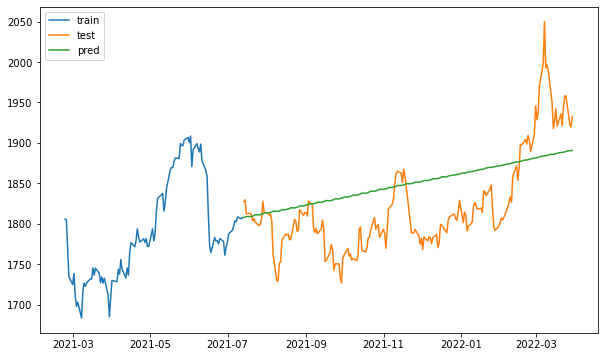

In [210]:
#sarimax exog silver
future_forecast = sarimax_final_model_exog_sil.forecast(185,exog = ts_df_sil_lag1_test)

sarimax_pred_df = pd.DataFrame(ts_df_test.values,columns = ['actual'],index = ts_df_test.index)
sarimax_pred_df['pred'] = future_forecast.values

display(np.sqrt(mean_squared_error(sarimax_pred_df['pred'],sarimax_pred_df['actual'])))

plt.figure(figsize=(10,6))

plt.plot(ts_df_train[-100:],label = 'train')
plt.plot(ts_df_test, label = 'test')
plt.plot(sarimax_pred_df['pred'], label = 'pred')
plt.legend()

We can see that our sarimax model with silver prices achieved a rmse of 54 and does not predicted better than our sarima model

In [215]:
sarimax = SARIMAX(endog = ts_df_train,
                                             order = (5,1,5),
                                             seasonal_order = (0,1,0,5),
                  exog = rolling_train
                                             
                            )

sarimax_final_model_exog_roll = sarimax.fit()

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.01810D+00    |proj g|=  9.54257D-02

At iterate    5    f=  3.99469D+00    |proj g|=  2.04622D-01

At iterate   10    f=  3.97891D+00    |proj g|=  1.91220D-01

At iterate   15    f=  3.96898D+00    |proj g|=  1.43179D-01

At iterate   20    f=  3.96566D+00    |proj g|=  4.99663D-02

At iterate   25    f=  3.96325D+00    |proj g|=  1.43183D-01

At iterate   30    f=  3.96222D+00    |proj g|=  3.20985D-02

At iterate   35    f=  3.96076D+00    |proj g|=  1.00677D-01

At iterate   40    f=  3.96032D+00    |proj g|=  9.42371D-02

At iterate   45    f=  3.95946D+00    |proj g|=  7.35535D-02

At iterate   50    f=  3.95893D+00    |proj g|=  3.68422D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


204.7694960506889

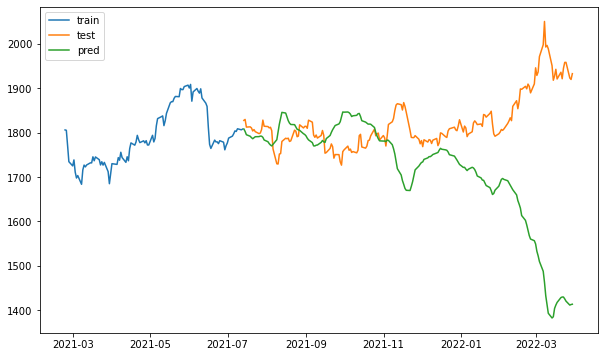

In [217]:
#sarimax exog roll

future_forecast = sarimax_final_model_exog_roll.forecast(185,exog = rolling_test)

sarimax_pred_df = pd.DataFrame(ts_df_test.values,columns = ['actual'],index = ts_df_test.index)
sarimax_pred_df['pred'] = future_forecast.values

display(np.sqrt(mean_squared_error(sarimax_pred_df['pred'],sarimax_pred_df['actual'])))

plt.figure(figsize=(10,6))

plt.plot(ts_df_train[-100:],label = 'train')
plt.plot(ts_df_test, label = 'test')
plt.plot(sarimax_pred_df['pred'], label = 'pred')
plt.legend()

When we try to predict prices with a sarimax model with rolling prices, the model does very well in predicting the inverse. This has achieved an rmse of 204 which does not beat our sarima model of 48 rmse. We will now run the sarima model through our backtester.

In [220]:
#parsing validation_df
# we will use this df to validate our trades

valid_df = pd.read_pickle(get_his_data_filename('XAU_USD','D',time_from = '2015',time_to = '180422'))

valid_df['time'] = valid_df['time'].apply(get_utc_dt_from_string)

valid_df['time'] = valid_df['time'].apply(astimezone)

valid_df = valid_df.set_index('time')

In [222]:
display(ts_df_test.index)

# separating out only the relevant prices to validate our test predictions

valid_df = valid_df['2021-07-14':]

valid_df

DatetimeIndex(['2021-07-14 05:00:00+08:00', '2021-07-15 05:00:00+08:00',
               '2021-07-16 05:00:00+08:00', '2021-07-19 05:00:00+08:00',
               '2021-07-20 05:00:00+08:00', '2021-07-21 05:00:00+08:00',
               '2021-07-22 05:00:00+08:00', '2021-07-23 05:00:00+08:00',
               '2021-07-26 05:00:00+08:00', '2021-07-27 05:00:00+08:00',
               ...
               '2022-03-17 05:00:00+08:00', '2022-03-18 05:00:00+08:00',
               '2022-03-21 05:00:00+08:00', '2022-03-22 05:00:00+08:00',
               '2022-03-23 05:00:00+08:00', '2022-03-24 05:00:00+08:00',
               '2022-03-25 05:00:00+08:00', '2022-03-28 05:00:00+08:00',
               '2022-03-29 05:00:00+08:00', '2022-03-30 05:00:00+08:00'],
              dtype='datetime64[ns, Singapore]', name='time', length=185, freq=None)

,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
time,,,,,,,,,,,,,
2021-07-14 05:00:00+08:00,43278,1807.815,1829.880,1804.586,1827.385,1807.631,1829.707,1804.392,1827.257,1807.999,1830.063,1804.779,1827.513
2021-07-15 05:00:00+08:00,36635,1827.575,1834.195,1820.375,1829.530,1827.140,1834.013,1820.185,1829.321,1828.010,1834.404,1820.565,1829.740
2021-07-16 05:00:00+08:00,45559,1829.660,1832.066,1809.030,1812.255,1829.367,1831.897,1808.798,1811.837,1829.953,1832.276,1809.185,1812.673
2021-07-19 05:00:00+08:00,50007,1811.110,1817.420,1795.080,1812.845,1810.528,1817.240,1794.894,1812.585,1811.693,1817.600,1795.263,1813.105
2021-07-20 05:00:00+08:00,45002,1812.995,1825.006,1805.130,1810.345,1812.663,1824.847,1804.949,1810.138,1813.327,1825.179,1805.309,1810.552
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-12 05:00:00+08:00,496119,1952.640,1978.686,1949.755,1966.585,1952.355,1978.558,1949.590,1966.400,1952.925,1978.817,1949.885,1966.770
2022-04-13 05:00:00+08:00,374659,1967.540,1981.566,1962.950,1977.835,1967.320,1981.424,1962.803,1977.694,1967.760,1981.710,1963.075,1977.976
2022-04-14 05:00:00+08:00,385587,1977.375,1980.435,1960.600,1973.395,1977.216,1980.293,1960.315,1973.084,1977.534,1980.580,1960.868,1973.706


In [272]:
# sarima/sarimax backtester
# our trading strategy is that we will fit a sarima model and then predict the next day price 
#\n with take profit and stop loss level to be played out
# then, we will refit and train our model to update it with the actual data point of the next day
#\n and then predict 1 time step ahead again

def time_series_cerebro(train,test,p,d,q,valid_df,P=0,D=0,Q=0,S=0, exog_train=None, exog_test=None):
    
    results_columns = ['buy_time','initial_price','pred_price','decision','end_time','suc_price','fail_price','profit']

    order_book_df = pd.DataFrame(columns = results_columns)

    suc_count = 0
    fail_count = 0
    
    for i in range(len(test)):
        
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
    
        sarimax = SARIMAX(endog = train,
                    order = (p,d,q),
                    seasonal_order = (P,D,Q,S),
                    exog = exog_train)
    
        model = sarimax.fit()
        
        # include exog variables if doing sarimax
        if exog_test is not None:
            
            exog_entry = pd.Series(exog_test.iloc[i],index = [exog_test.index[i]])

            print(exog_entry)
            
            # we will predict 1 time step ahead
            
            pred_price = float(model.forecast(1,exog = exog_entry).values)
            
        else:
            
            # if sarima, no exog variables and we will straight away predict 1 time step ahead
            
            pred_price = float(model.forecast(1).values)
        
        # including only relevant validation candles and exclude all candles before that
        
        partition_validation_df = valid_df.iloc[i:]
        
        buy_time = train.iloc[-1:].index[0]
        
        current_price = train.iloc[-1]['mid_c']
        
        difference = abs(pred_price - current_price)
        
        # defining entry price and tp/sl
        # we will look at the ask prices for long and bid prices for short
        
        entry_long_price = partition_validation_df.iloc[0]['ask_o']
        
        entry_short_price = partition_validation_df.iloc[0]['bid_o']
        
        long_tp_price = entry_long_price + (difference)
    
        long_sl_price = entry_long_price - (difference)
    
        short_tp_price = entry_short_price - (difference)
        
        short_sl_price = entry_short_price + (difference)
        
        if pred_price>current_price:
            decision = 1

        if pred_price<current_price:
            decision = -1

        else: 
            pass
        
        if decision ==1:
            
            for y in partition_validation_df.index:
                
                # if bid close crosses above the long tp price, it is a success
                
                if partition_validation_df.loc[y]['bid_c']>=long_tp_price:

                    suc_price = partition_validation_df.loc[y]['bid_c']
                    
                    profit = long_tp_price - entry_long_price
                    
                    end_time = y

                    order_book_df = order_book_df.append(pd.Series([buy_time,current_price,pred_price,decision,end_time,suc_price,np.nan,profit],
                                                                  index= results_columns),
                                                                    ignore_index=True)

                    suc_count +=1

                    break
                    
                # if bid close crosses below the long sl price, it is a loss
                
                if partition_validation_df.loc[y]['bid_c']<=long_sl_price:

                    fail_price = partition_validation_df.loc[y]['bid_c']
                    
                    profit = long_sl_price - entry_long_price
                    
                    end_time = y

                    order_book_df = order_book_df.append(pd.Series([buy_time,current_price,pred_price,decision,end_time,np.nan,fail_price,profit],
                                                                  index= results_columns),
                                                                    ignore_index=True)

                    fail_count +=1

                    break
        
        if decision == -1:
            
            for y in partition_validation_df.index:
                
                #if ask ask close crosses below the short tp price, it is a success
                
                if partition_validation_df.loc[y]['ask_c']<=short_tp_price:

                    suc_price = partition_validation_df.loc[y]['ask_c']
                    
                    profit = entry_short_price - short_tp_price

                    end_time = y

                    order_book_df = order_book_df.append(pd.Series([buy_time,current_price,pred_price,decision,end_time,suc_price,np.nan,profit],
                                                                  index= results_columns),
                                                                    ignore_index=True)
                    
                    suc_count +=1

                    break
                
                #if ask ask close crosses above the short sl price, it is a loss
                
                if partition_validation_df.loc[y]['ask_c']>=short_sl_price:

                    fail_price = partition_validation_df.loc[y]['ask_c']
                    
                    profit = entry_short_price - short_sl_price
                    
                    end_time = y
                    
                    order_book_df = order_book_df.append(pd.Series([buy_time,current_price,pred_price,decision,end_time,np.nan,fail_price,profit],
                                                                  index= results_columns),
                                                                    ignore_index=True)
                    
                    fail_count +=1

                    break

        #for sarimax model, we will need to append the new exog variables to the train set to predict new price
        
        if exog_test is not None:
            exog_train = exog_train.append(pd.Series(exog_test.iloc[i],index=[exog_test.index[i]]))
            train = train.append(test.iloc[i])
            print(exog_train.tail(3))
        
        # for sarima model, we will only need to append the next actual gold price to update the model and 
        #\n make a new prediction
        
        else:
            train = train.append(test.iloc[i])
            print(train.tail(3))
        
    print (f'suc_count: {suc_count}')
    print (f'fail_count: {fail_count}') 
    print (f'suc_percentage: {suc_count/(suc_count+fail_count)}')
    print (f'profit: {sum(order_book_df["profit"])}')

    return order_book_df

In [273]:
sarima_order_book_df = time_series_cerebro(ts_df_train,ts_df_test,p =5,d=1,q=5,valid_df=valid_df,
                                           P=0,D=1,Q=0,S=5, exog_train=None, exog_test=None)

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02373D+00    |proj g|=  1.09789D-01

At iterate    5    f=  4.00392D+00    |proj g|=  6.69196D-02

At iterate   10    f=  3.97226D+00    |proj g|=  7.01961D-02

At iterate   15    f=  3.95865D+00    |proj g|=  1.11358D-01

At iterate   20    f=  3.95409D+00    |proj g|=  1.43140D-01

At iterate   25    f=  3.95312D+00    |proj g|=  8.55020D-02

At iterate   30    f=  3.95278D+00    |proj g|=  3.76494D-03

At iterate   35    f=  3.95277D+00    |proj g|=  1.99778D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   40    f=  3.95277D+00    |proj g|=  6.74696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     40     59      1     0     0   6.747D-04   3.953D+00
  F =   3.9527657666024201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-12 05:00:00+08:00  1806.145
2021-07-13 05:00:00+08:00  1807.710
2021-07-14 05:00:00+08:00  1827.385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02498D+00    |proj g|=  1.08272D-01

At iterate    5    f=  4.00375D+00    |proj g|=  9.92718D-02

At iterate   10    f=  3.97371D+00    |proj g|=  2.17819D-01

At iterate   15    f=  3.95934D+00    |proj g|=  4.92238D-02

At iterate   20    f=  3.95399D+00    |proj g|=  6.18299D-02

At iterate   25    f=  3.95327D+00    |proj g|=  1.88620D-02

At iterate   30    f=  3.95320D+00    |proj g|=  1.33067D-02

At iterate   35    f=  3.95319D+00    |proj g|=  7.55599D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     57      1     0     0   7.556D-04   3.953D+00
  F =   3.9531856801773411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-13 05:00:00+08:00  1807.710
2021-07-14 05:00:00+08:00  1827.385
2021-07-15 05:00:00+08:00  1829.530
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02497D+00    |proj g|=  1.07976D-01

At iterate    5    f=  4.00391D+00    |proj g|=  2.51064D-01

At iterate   10    f=  3.97873D+00    |proj g|=  8.63958D-02

At iterate   15    f=  3.95783D+00    |proj g|=  1.69360D-01

At iterate   20    f=  3.95503D+00    |proj g|=  5.69682D-02

At iterate   25    f=  3.95357D+00    |proj g|=  7.62739D-02

At iterate   30    f=  3.95295D+00    |proj g|=  9.78412D-03

At iterate   35    f=  3.95292D+00    |proj g|=  2.45264D-03

At iterate   40    f=  3.95291D+00    |proj g|=  1.38486D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-14 05:00:00+08:00  1827.385
2021-07-15 05:00:00+08:00  1829.530
2021-07-16 05:00:00+08:00  1812.255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02516D+00    |proj g|=  1.08423D-01

At iterate    5    f=  4.00253D+00    |proj g|=  8.39635D-02

At iterate   10    f=  3.97773D+00    |proj g|=  8.08056D-02

At iterate   15    f=  3.96000D+00    |proj g|=  2.30772D-01

At iterate   20    f=  3.95706D+00    |proj g|=  1.90268D-01

At iterate   25    f=  3.95445D+00    |proj g|=  7.59317D-02

At iterate   30    f=  3.95346D+00    |proj g|=  1.10349D-02

At iterate   35    f=  3.95327D+00    |proj g|=  1.20755D-02

At iterate   40    f=  3.95326D+00    |proj g|=  1.78440D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   45    f=  3.95325D+00    |proj g|=  2.92566D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     45     70      1     0     0   2.926D-03   3.953D+00
  F =   3.9532549668709769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-15 05:00:00+08:00  1829.530
2021-07-16 05:00:00+08:00  1812.255
2021-07-19 05:00:00+08:00  1812.845
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02491D+00    |proj g|=  1.08391D-01

At iterate    5    f=  4.00272D+00    |proj g|=  8.15313D-02

At iterate   10    f=  3.97349D+00    |proj g|=  1.56758D-01

At iterate   15    f=  3.95853D+00    |proj g|=  8.34420D-02

At iterate   20    f=  3.95507D+00    |proj g|=  7.52276D-02

At iterate   25    f=  3.95389D+00    |proj g|=  7.99337D-02

At iterate   30    f=  3.95300D+00    |proj g|=  2.03067D-02

At iterate   35    f=  3.95294D+00    |proj g|=  1.67791D-03

At iterate   40    f=  3.95294D+00    |proj g|=  2.07933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-16 05:00:00+08:00  1812.255
2021-07-19 05:00:00+08:00  1812.845
2021-07-20 05:00:00+08:00  1810.345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02465D+00    |proj g|=  1.08351D-01

At iterate    5    f=  4.00251D+00    |proj g|=  8.15845D-02

At iterate   10    f=  3.97496D+00    |proj g|=  1.45138D-01

At iterate   15    f=  3.95844D+00    |proj g|=  1.48625D-01

At iterate   20    f=  3.95515D+00    |proj g|=  1.66406D-01

At iterate   25    f=  3.95267D+00    |proj g|=  4.05241D-02

At iterate   30    f=  3.95265D+00    |proj g|=  5.23415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-19 05:00:00+08:00  1812.845
2021-07-20 05:00:00+08:00  1810.345
2021-07-21 05:00:00+08:00  1803.505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02439D+00    |proj g|=  1.08415D-01

At iterate    5    f=  4.00204D+00    |proj g|=  8.35907D-02

At iterate   10    f=  3.97770D+00    |proj g|=  7.69652D-02

At iterate   15    f=  3.95826D+00    |proj g|=  2.29680D-01

At iterate   20    f=  3.95414D+00    |proj g|=  1.00960D-01

At iterate   25    f=  3.95288D+00    |proj g|=  4.73416D-02

At iterate   30    f=  3.95251D+00    |proj g|=  4.32630D-02

At iterate   35    f=  3.95244D+00    |proj g|=  1.04607D-02

At iterate   40    f=  3.95243D+00    |proj g|=  4.59880D-03

At iterate   45    f=  3.95243D+00    |proj g|=  9.55608D-04


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  3.95243D+00    |proj g|=  1.14744D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.147D-03   3.952D+00
  F =   3.9524304199336449     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-20 05:00:00+08:00  1810.345
2021-07-21 05:00:00+08:00  1803.505
2021-07-22 05:00:00+08:00  1806.660
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02414D+00    |proj g|=  1.08355D-01

At iterate    5    f=  4.00178D+00    |proj g|=  8.34975D-02

At iterate   10    f=  3.97707D+00    |proj g|=  8.19366D-02

At iterate   15    f=  3.95995D+00    |proj g|=  2.10003D-01

At iterate   20    f=  3.95422D+00    |proj g|=  1.29564D-01

At iterate   25    f=  3.95235D+00    |proj g|=  4.38538D-02

At iterate   30    f=  3.95220D+00    |proj g|=  2.42719D-02

At iterate   35    f=  3.95216D+00    |proj g|=  9.87482D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     57      1     0     0   9.875D-04   3.952D+00
  F =   3.9521565119771358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-21 05:00:00+08:00  1803.505
2021-07-22 05:00:00+08:00  1806.660
2021-07-23 05:00:00+08:00  1801.975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02400D+00    |proj g|=  1.08449D-01

At iterate    5    f=  4.00163D+00    |proj g|=  8.18171D-02

At iterate   10    f=  3.97024D+00    |proj g|=  1.90604D-01

At iterate   15    f=  3.95865D+00    |proj g|=  2.17160D-01

At iterate   20    f=  3.95339D+00    |proj g|=  7.98247D-02

At iterate   25    f=  3.95240D+00    |proj g|=  8.51660D-02

At iterate   30    f=  3.95193D+00    |proj g|=  4.97730D-03

At iterate   35    f=  3.95193D+00    |proj g|=  1.85961D-03

At iterate   40    f=  3.95193D+00    |proj g|=  7.24482D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-22 05:00:00+08:00  1806.660
2021-07-23 05:00:00+08:00  1801.975
2021-07-26 05:00:00+08:00  1797.575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02379D+00    |proj g|=  1.08370D-01

At iterate    5    f=  4.00177D+00    |proj g|=  8.03356D-02

At iterate   10    f=  3.97090D+00    |proj g|=  1.50619D-01

At iterate   15    f=  3.95650D+00    |proj g|=  2.67857D-01

At iterate   20    f=  3.95394D+00    |proj g|=  3.85190D-02

At iterate   25    f=  3.95272D+00    |proj g|=  3.85793D-02

At iterate   30    f=  3.95188D+00    |proj g|=  5.71916D-02

At iterate   35    f=  3.95168D+00    |proj g|=  1.93100D-02

At iterate   40    f=  3.95167D+00    |proj g|=  8.76191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-23 05:00:00+08:00  1801.975
2021-07-26 05:00:00+08:00  1797.575
2021-07-27 05:00:00+08:00  1798.995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02354D+00    |proj g|=  1.08357D-01

At iterate    5    f=  4.00172D+00    |proj g|=  7.98242D-02

At iterate   10    f=  3.97009D+00    |proj g|=  1.25071D-01

At iterate   15    f=  3.95616D+00    |proj g|=  1.03534D-01

At iterate   20    f=  3.95178D+00    |proj g|=  3.73785D-02

At iterate   25    f=  3.95138D+00    |proj g|=  1.99407D-02

At iterate   30    f=  3.95137D+00    |proj g|=  9.80927D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-26 05:00:00+08:00  1797.575
2021-07-27 05:00:00+08:00  1798.995
2021-07-28 05:00:00+08:00  1806.895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02331D+00    |proj g|=  1.08527D-01

At iterate    5    f=  4.00148D+00    |proj g|=  7.97172D-02

At iterate   10    f=  3.97082D+00    |proj g|=  2.38515D-01

At iterate   15    f=  3.95697D+00    |proj g|=  6.28277D-02

At iterate   20    f=  3.95257D+00    |proj g|=  8.22485D-02

At iterate   25    f=  3.95146D+00    |proj g|=  3.44057D-02

At iterate   30    f=  3.95117D+00    |proj g|=  6.93414D-03

At iterate   35    f=  3.95117D+00    |proj g|=  2.88843D-03

At iterate   40    f=  3.95117D+00    |proj g|=  2.69638D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     60      1     0     0   2.650D-03   3.951D+00
  F =   3.9511705033503008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-27 05:00:00+08:00  1798.995
2021-07-28 05:00:00+08:00  1806.895
2021-07-29 05:00:00+08:00  1827.975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02376D+00    |proj g|=  1.08155D-01

At iterate    5    f=  4.00259D+00    |proj g|=  9.47436D-02

At iterate   10    f=  3.96769D+00    |proj g|=  8.74111D-02

At iterate   15    f=  3.95424D+00    |proj g|=  3.71100D-01

At iterate   20    f=  3.95180D+00    |proj g|=  2.21860D-02

At iterate   25    f=  3.95170D+00    |proj g|=  5.69621D-03

At iterate   30    f=  3.95169D+00    |proj g|=  3.32449D-03

At iterate   35    f=  3.95169D+00    |proj g|=  4.56431D-04

At iterate   40    f=  3.95169D+00    |proj g|=  8.44537D-04

At iterate   45    f=  3.95169D+00    |proj g|=  1.93082D-03


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  3.95169D+00    |proj g|=  5.91760D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     68      1     0     0   5.918D-03   3.952D+00
  F =   3.9516880726823427     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-28 05:00:00+08:00  1806.895
2021-07-29 05:00:00+08:00  1827.975
2021-07-30 05:00:00+08:00  1814.180
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02383D+00    |proj g|=  1.07707D-01

At iterate    5    f=  4.00165D+00    |proj g|=  8.17050D-02

At iterate   10    f=  3.97134D+00    |proj g|=  2.55628D-01

At iterate   15    f=  3.95909D+00    |proj g|=  1.50870D-01

At iterate   20    f=  3.95403D+00    |proj g|=  1.21883D-01

At iterate   25    f=  3.95269D+00    |proj g|=  2.61275D-02

At iterate   30    f=  3.95195D+00    |proj g|=  3.74129D-02

At iterate   35    f=  3.95181D+00    |proj g|=  2.20154D-03

At iterate   40    f=  3.95181D+00    |proj g|=  8.61646D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-29 05:00:00+08:00  1827.975
2021-07-30 05:00:00+08:00  1814.180
2021-08-02 05:00:00+08:00  1813.494
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02355D+00    |proj g|=  1.07681D-01

At iterate    5    f=  4.00248D+00    |proj g|=  9.83227D-02

At iterate   10    f=  3.97024D+00    |proj g|=  9.01792D-02

At iterate   15    f=  3.95693D+00    |proj g|=  4.88679D-01

At iterate   20    f=  3.95350D+00    |proj g|=  3.21174D-02

At iterate   25    f=  3.95172D+00    |proj g|=  1.29915D-01

At iterate   30    f=  3.95153D+00    |proj g|=  3.50872D-03

At iterate   35    f=  3.95153D+00    |proj g|=  3.18711D-03

At iterate   40    f=  3.95153D+00    |proj g|=  1.67962D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-07-30 05:00:00+08:00  1814.180
2021-08-02 05:00:00+08:00  1813.494
2021-08-03 05:00:00+08:00  1810.450
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02329D+00    |proj g|=  1.07663D-01

At iterate    5    f=  4.00076D+00    |proj g|=  8.26481D-02

At iterate   10    f=  3.97038D+00    |proj g|=  2.00946D-01

At iterate   15    f=  3.95707D+00    |proj g|=  7.49353D-02

At iterate   20    f=  3.95393D+00    |proj g|=  5.45471D-02

At iterate   25    f=  3.95196D+00    |proj g|=  4.77049D-02

At iterate   30    f=  3.95127D+00    |proj g|=  1.89877D-02

At iterate   35    f=  3.95124D+00    |proj g|=  2.91935D-03

At iterate   40    f=  3.95124D+00    |proj g|=  2.99703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-02 05:00:00+08:00  1813.494
2021-08-03 05:00:00+08:00  1810.450
2021-08-04 05:00:00+08:00  1811.860
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02303D+00    |proj g|=  1.07543D-01

At iterate    5    f=  4.00059D+00    |proj g|=  8.28335D-02

At iterate   10    f=  3.97117D+00    |proj g|=  1.23659D-01

At iterate   15    f=  3.95574D+00    |proj g|=  1.02371D-01

At iterate   20    f=  3.95295D+00    |proj g|=  5.15666D-02

At iterate   25    f=  3.95104D+00    |proj g|=  6.64666D-02

At iterate   30    f=  3.95097D+00    |proj g|=  6.41039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-08-03 05:00:00+08:00  1810.45
2021-08-04 05:00:00+08:00  1811.86
2021-08-05 05:00:00+08:00  1804.17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02285D+00    |proj g|=  1.07600D-01

At iterate    5    f=  4.00095D+00    |proj g|=  8.03441D-02

At iterate   10    f=  3.97056D+00    |proj g|=  1.80788D-01

At iterate   15    f=  3.95595D+00    |proj g|=  1.30629D-01

At iterate   20    f=  3.95282D+00    |proj g|=  8.22250D-02

At iterate   25    f=  3.95097D+00    |proj g|=  1.71266D-02

At iterate   30    f=  3.95077D+00    |proj g|=  6.34081D-03

At iterate   35    f=  3.95076D+00    |proj g|=  9.22609D-04

At iterate   40    f=  3.95076D+00    |proj g|=  2.43819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-04 05:00:00+08:00  1811.860
2021-08-05 05:00:00+08:00  1804.170
2021-08-06 05:00:00+08:00  1763.085
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02489D+00    |proj g|=  1.06656D-01

At iterate    5    f=  3.99352D+00    |proj g|=  7.36953D-02

At iterate   10    f=  3.97083D+00    |proj g|=  5.66026D-02

At iterate   15    f=  3.95555D+00    |proj g|=  3.01345D-01

At iterate   20    f=  3.95423D+00    |proj g|=  2.32060D-02

At iterate   25    f=  3.95383D+00    |proj g|=  2.92736D-02

At iterate   30    f=  3.95381D+00    |proj g|=  9.49542D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-05 05:00:00+08:00  1804.170
2021-08-06 05:00:00+08:00  1763.085
2021-08-09 05:00:00+08:00  1729.675
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02628D+00    |proj g|=  1.05947D-01

At iterate    5    f=  4.00341D+00    |proj g|=  8.94931D-02

At iterate   10    f=  3.98221D+00    |proj g|=  4.99361D-02

At iterate   15    f=  3.96099D+00    |proj g|=  3.83909D-01

At iterate   20    f=  3.95634D+00    |proj g|=  2.86991D-02

At iterate   25    f=  3.95546D+00    |proj g|=  2.48700D-02

At iterate   30    f=  3.95545D+00    |proj g|=  1.21509D-03

At iterate   35    f=  3.95544D+00    |proj g|=  1.85353D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-06 05:00:00+08:00  1763.085
2021-08-09 05:00:00+08:00  1729.675
2021-08-10 05:00:00+08:00  1729.125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02600D+00    |proj g|=  1.05953D-01

At iterate    5    f=  4.00310D+00    |proj g|=  8.85410D-02

At iterate   10    f=  3.98169D+00    |proj g|=  4.90259D-02

At iterate   15    f=  3.96147D+00    |proj g|=  1.82629D-01

At iterate   20    f=  3.95775D+00    |proj g|=  3.37874D-02

At iterate   25    f=  3.95521D+00    |proj g|=  6.92845D-02

At iterate   30    f=  3.95514D+00    |proj g|=  1.84596D-03

At iterate   35    f=  3.95513D+00    |proj g|=  1.73318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-09 05:00:00+08:00  1729.675
2021-08-10 05:00:00+08:00  1729.125
2021-08-11 05:00:00+08:00  1751.550
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02621D+00    |proj g|=  1.05784D-01

At iterate    5    f=  4.00479D+00    |proj g|=  7.67080D-02

At iterate   10    f=  3.98103D+00    |proj g|=  3.95520D-02

At iterate   15    f=  3.96298D+00    |proj g|=  4.99659D-02

At iterate   20    f=  3.95706D+00    |proj g|=  4.11777D-02

At iterate   25    f=  3.95567D+00    |proj g|=  1.03875D-02

At iterate   30    f=  3.95565D+00    |proj g|=  6.91519D-03

At iterate   35    f=  3.95564D+00    |proj g|=  6.41747D-04

At iterate   40    f=  3.95564D+00    |proj g|=  2.34877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-10 05:00:00+08:00  1729.125
2021-08-11 05:00:00+08:00  1751.550
2021-08-12 05:00:00+08:00  1752.610
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02591D+00    |proj g|=  1.06125D-01

At iterate    5    f=  4.00394D+00    |proj g|=  7.90964D-02

At iterate   10    f=  3.97982D+00    |proj g|=  6.28629D-02

At iterate   15    f=  3.95908D+00    |proj g|=  1.84607D-01

At iterate   20    f=  3.95640D+00    |proj g|=  3.09690D-02

At iterate   25    f=  3.95541D+00    |proj g|=  8.83484D-03

At iterate   30    f=  3.95540D+00    |proj g|=  2.25095D-03

At iterate   35    f=  3.95539D+00    |proj g|=  5.87344D-04

At iterate   40    f=  3.95539D+00    |proj g|=  2.59684D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-08-11 05:00:00+08:00  1751.55
2021-08-12 05:00:00+08:00  1752.61
2021-08-13 05:00:00+08:00  1779.90
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02757D+00    |proj g|=  1.06361D-01

At iterate    5    f=  4.00663D+00    |proj g|=  1.44683D-01

At iterate   10    f=  3.97770D+00    |proj g|=  5.53152D-02

At iterate   15    f=  3.96053D+00    |proj g|=  1.07886D-01

At iterate   20    f=  3.95833D+00    |proj g|=  3.65348D-02

At iterate   25    f=  3.95599D+00    |proj g|=  4.11380D-02

At iterate   30    f=  3.95597D+00    |proj g|=  6.00930D-03

At iterate   35    f=  3.95596D+00    |proj g|=  1.04567D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95596D+00    |proj g|=  2.39255D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     75      2     0     0   1.320D-03   3.956D+00
  F =   3.9559634691457406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-08-12 05:00:00+08:00  1752.61
2021-08-13 05:00:00+08:00  1779.90
2021-08-16 05:00:00+08:00  1787.20
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02749D+00    |proj g|=  1.06379D-01

At iterate    5    f=  4.00746D+00    |proj g|=  2.20551D-01

At iterate   10    f=  3.98189D+00    |proj g|=  6.13745D-02

At iterate   15    f=  3.96099D+00    |proj g|=  3.35116D-01

At iterate   20    f=  3.95699D+00    |proj g|=  6.07851D-02

At iterate   25    f=  3.95572D+00    |proj g|=  7.30941D-03

At iterate   30    f=  3.95572D+00    |proj g|=  3.53876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of act

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-08-13 05:00:00+08:00  1779.90
2021-08-16 05:00:00+08:00  1787.20
2021-08-17 05:00:00+08:00  1786.07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02721D+00    |proj g|=  1.06366D-01

At iterate    5    f=  4.00841D+00    |proj g|=  2.57018D-01

At iterate   10    f=  3.97802D+00    |proj g|=  1.19838D-01

At iterate   15    f=  3.96049D+00    |proj g|=  2.73347D-01

At iterate   20    f=  3.95717D+00    |proj g|=  4.47767D-02

At iterate   25    f=  3.95544D+00    |proj g|=  4.17747D-03

At iterate   30    f=  3.95543D+00    |proj g|=  2.17113D-03

At iterate   35    f=  3.95543D+00    |proj g|=  1.69713D-03

At iterate   40    f=  3.95543D+00    |proj g|=  5.30410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-16 05:00:00+08:00  1787.200
2021-08-17 05:00:00+08:00  1786.070
2021-08-18 05:00:00+08:00  1787.326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02691D+00    |proj g|=  1.06362D-01

At iterate    5    f=  4.00770D+00    |proj g|=  2.54247D-01

At iterate   10    f=  3.97836D+00    |proj g|=  1.06198D-01

At iterate   15    f=  3.95982D+00    |proj g|=  2.12040D-01

At iterate   20    f=  3.95592D+00    |proj g|=  8.29514D-02

At iterate   25    f=  3.95521D+00    |proj g|=  2.10681D-02

At iterate   30    f=  3.95516D+00    |proj g|=  5.62399D-03

At iterate   35    f=  3.95515D+00    |proj g|=  5.21238D-03

At iterate   40    f=  3.95515D+00    |proj g|=  1.04534D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     65      1     0     0   1.251D-03   3.955D+00
  F =   3.9551543389831814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-17 05:00:00+08:00  1786.070
2021-08-18 05:00:00+08:00  1787.326
2021-08-19 05:00:00+08:00  1779.936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02679D+00    |proj g|=  1.06191D-01

At iterate    5    f=  4.00719D+00    |proj g|=  2.55816D-01

At iterate   10    f=  3.97784D+00    |proj g|=  1.19829D-01

At iterate   15    f=  3.95910D+00    |proj g|=  9.05218D-02

At iterate   20    f=  3.95519D+00    |proj g|=  6.41035D-02

At iterate   25    f=  3.95497D+00    |proj g|=  1.31845D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-18 05:00:00+08:00  1787.326
2021-08-19 05:00:00+08:00  1779.936
2021-08-20 05:00:00+08:00  1781.240
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02654D+00    |proj g|=  1.07405D-01

At iterate    5    f=  4.00545D+00    |proj g|=  2.28712D-01

At iterate   10    f=  3.97844D+00    |proj g|=  6.49268D-02

At iterate   15    f=  3.95950D+00    |proj g|=  1.46457D-01

At iterate   20    f=  3.95539D+00    |proj g|=  1.92568D-02

At iterate   25    f=  3.95486D+00    |proj g|=  4.48382D-02

At iterate   30    f=  3.95469D+00    |proj g|=  3.33687D-03

At iterate   35    f=  3.95469D+00    |proj g|=  2.54786D-03

At iterate   40    f=  3.95469D+00    |proj g|=  2.17338D-03

At iterate   45    f=  3.95469D+00    |proj g|=  1.93959D-03

           * * *

Tit   = total 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-19 05:00:00+08:00  1779.936
2021-08-20 05:00:00+08:00  1781.240
2021-08-23 05:00:00+08:00  1805.445
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02740D+00    |proj g|=  1.08437D-01

At iterate    5    f=  4.00868D+00    |proj g|=  2.91180D-01

At iterate   10    f=  3.98140D+00    |proj g|=  5.22480D-02

At iterate   15    f=  3.96047D+00    |proj g|=  2.20678D-01

At iterate   20    f=  3.95779D+00    |proj g|=  9.73915D-02

At iterate   25    f=  3.95583D+00    |proj g|=  5.23962D-02

At iterate   30    f=  3.95557D+00    |proj g|=  3.25900D-03

At iterate   35    f=  3.95557D+00    |proj g|=  5.63958D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     55      1     0     0   1.977D-03   3.956D+00
  F =   3.9555659515321877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-20 05:00:00+08:00  1781.240
2021-08-23 05:00:00+08:00  1805.445
2021-08-24 05:00:00+08:00  1803.075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02712D+00    |proj g|=  1.08426D-01

At iterate    5    f=  4.00785D+00    |proj g|=  2.87229D-01

At iterate   10    f=  3.98002D+00    |proj g|=  1.46880D-01

At iterate   15    f=  3.96226D+00    |proj g|=  4.82830D-01

At iterate   20    f=  3.95914D+00    |proj g|=  9.37582D-02

At iterate   25    f=  3.95561D+00    |proj g|=  7.23137D-02

At iterate   30    f=  3.95533D+00    |proj g|=  3.37836D-02

At iterate   35    f=  3.95529D+00    |proj g|=  2.09407D-02

At iterate   40    f=  3.95529D+00    |proj g|=  3.24565D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     65      1     0     0   7.475D-04   3.955D+00
  F =   3.9552855017008874     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-23 05:00:00+08:00  1805.445
2021-08-24 05:00:00+08:00  1803.075
2021-08-25 05:00:00+08:00  1790.570
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02748D+00    |proj g|=  1.08901D-01

At iterate    5    f=  4.00437D+00    |proj g|=  8.57213D-02

At iterate   10    f=  3.98057D+00    |proj g|=  5.98552D-02

At iterate   15    f=  3.96211D+00    |proj g|=  6.45887D-02

At iterate   20    f=  3.95792D+00    |proj g|=  1.30856D-01

At iterate   25    f=  3.95565D+00    |proj g|=  1.10205D-01

At iterate   30    f=  3.95540D+00    |proj g|=  2.30191D-02

At iterate   35    f=  3.95533D+00    |proj g|=  2.30037D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     59      1     0     0   5.713D-04   3.955D+00
  F =   3.9553324428175616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-24 05:00:00+08:00  1803.075
2021-08-25 05:00:00+08:00  1790.570
2021-08-26 05:00:00+08:00  1791.990
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02723D+00    |proj g|=  1.08944D-01

At iterate    5    f=  4.00415D+00    |proj g|=  8.20939D-02

At iterate   10    f=  3.97430D+00    |proj g|=  1.56560D-01

At iterate   15    f=  3.95884D+00    |proj g|=  2.83919D-01

At iterate   20    f=  3.95634D+00    |proj g|=  3.59652D-02

At iterate   25    f=  3.95505D+00    |proj g|=  6.56231D-03

At iterate   30    f=  3.95503D+00    |proj g|=  1.11507D-03

At iterate   35    f=  3.95503D+00    |proj g|=  1.63082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-25 05:00:00+08:00  1790.570
2021-08-26 05:00:00+08:00  1791.990
2021-08-27 05:00:00+08:00  1817.425
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02952D+00    |proj g|=  1.06261D-01

At iterate    5    f=  4.00818D+00    |proj g|=  1.39944D-01

At iterate   10    f=  3.98275D+00    |proj g|=  5.49553D-02

At iterate   15    f=  3.96407D+00    |proj g|=  9.88620D-02

At iterate   20    f=  3.95761D+00    |proj g|=  8.90958D-02

At iterate   25    f=  3.95599D+00    |proj g|=  2.19026D-02

At iterate   30    f=  3.95597D+00    |proj g|=  3.08590D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-26 05:00:00+08:00  1791.990
2021-08-27 05:00:00+08:00  1817.425
2021-08-30 05:00:00+08:00  1810.360
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02921D+00    |proj g|=  1.06784D-01

At iterate    5    f=  4.00767D+00    |proj g|=  1.37976D-01

At iterate   10    f=  3.98288D+00    |proj g|=  5.69448D-02

At iterate   15    f=  3.96486D+00    |proj g|=  2.05032D-01

At iterate   20    f=  3.95835D+00    |proj g|=  5.19656D-02

At iterate   25    f=  3.95576D+00    |proj g|=  6.67402D-03

At iterate   30    f=  3.95575D+00    |proj g|=  5.21346D-03

At iterate   35    f=  3.95575D+00    |proj g|=  3.52272D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95575D+00    |proj g|=  9.35183D-04

At iterate   45    f=  3.95575D+00    |proj g|=  6.69778D-03

At iterate   50    f=  3.95575D+00    |proj g|=  2.27877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


   11     50     79      2     0     0   2.279D-03   3.956D+00
  F =   3.9557483385207366     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-27 05:00:00+08:00  1817.425
2021-08-30 05:00:00+08:00  1810.360
2021-08-31 05:00:00+08:00  1813.795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02899D+00    |proj g|=  1.06737D-01

At iterate    5    f=  4.00804D+00    |proj g|=  2.13795D-01

At iterate   10    f=  3.98340D+00    |proj g|=  5.52301D-02

At iterate   15    f=  3.96395D+00    |proj g|=  1.27143D-01

At iterate   20    f=  3.95729D+00    |proj g|=  9.71492D-02

At iterate   25    f=  3.95563D+00    |proj g|=  7.75392D-02

At iterate   30    f=  3.95545D+00    |proj g|=  3.16818D-03

At iterate   35    f=  3.95545D+00    |proj g|=  1.84205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-30 05:00:00+08:00  1810.360
2021-08-31 05:00:00+08:00  1813.795
2021-09-01 05:00:00+08:00  1814.145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02873D+00    |proj g|=  1.06726D-01

At iterate    5    f=  4.00513D+00    |proj g|=  8.45877D-02

At iterate   10    f=  3.98045D+00    |proj g|=  1.70000D-01

At iterate   15    f=  3.96251D+00    |proj g|=  2.39798D-01

At iterate   20    f=  3.95906D+00    |proj g|=  1.16044D-01

At iterate   25    f=  3.95572D+00    |proj g|=  1.13477D-01

At iterate   30    f=  3.95518D+00    |proj g|=  3.35235D-02

At iterate   35    f=  3.95517D+00    |proj g|=  1.41464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-08-31 05:00:00+08:00  1813.795
2021-09-01 05:00:00+08:00  1814.145
2021-09-02 05:00:00+08:00  1809.525
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02847D+00    |proj g|=  1.06719D-01

At iterate    5    f=  4.00755D+00    |proj g|=  2.14595D-01

At iterate   10    f=  3.98283D+00    |proj g|=  5.39420D-02

At iterate   15    f=  3.96327D+00    |proj g|=  7.48971D-02

At iterate   20    f=  3.95691D+00    |proj g|=  8.25722D-02

At iterate   25    f=  3.95494D+00    |proj g|=  3.18351D-02

At iterate   30    f=  3.95491D+00    |proj g|=  5.29175D-03

At iterate   35    f=  3.95490D+00    |proj g|=  2.24972D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-01 05:00:00+08:00  1814.145
2021-09-02 05:00:00+08:00  1809.525
2021-09-03 05:00:00+08:00  1827.800
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02884D+00    |proj g|=  1.05938D-01

At iterate    5    f=  4.00571D+00    |proj g|=  8.23979D-02

At iterate   10    f=  3.98131D+00    |proj g|=  8.28670D-02

At iterate   15    f=  3.96252D+00    |proj g|=  5.01222D-01

At iterate   20    f=  3.95880D+00    |proj g|=  1.09734D-01

At iterate   25    f=  3.95609D+00    |proj g|=  6.86363D-02

At iterate   30    f=  3.95537D+00    |proj g|=  6.65073D-02

At iterate   35    f=  3.95530D+00    |proj g|=  3.99051D-03

At iterate   40    f=  3.95530D+00    |proj g|=  2.50574D-03

At iterate   45    f=  3.95529D+00    |proj g|=  1.33008D-03

           * * *

Tit   = total 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-02 05:00:00+08:00  1809.525
2021-09-03 05:00:00+08:00  1827.800
2021-09-06 05:00:00+08:00  1823.340
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02853D+00    |proj g|=  1.06143D-01

At iterate    5    f=  4.00548D+00    |proj g|=  8.22744D-02

At iterate   10    f=  3.98117D+00    |proj g|=  8.12040D-02

At iterate   15    f=  3.96278D+00    |proj g|=  4.81888D-01

At iterate   20    f=  3.95829D+00    |proj g|=  4.47428D-02

At iterate   25    f=  3.95636D+00    |proj g|=  1.04718D-01

At iterate   30    f=  3.95515D+00    |proj g|=  3.18536D-02

At iterate   35    f=  3.95506D+00    |proj g|=  1.20869D-02

At iterate   40    f=  3.95505D+00    |proj g|=  1.49873D-03

At iterate   45    f=  3.95505D+00    |proj g|=  1.48277D-03

           * * *

Tit   = total 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-03 05:00:00+08:00  1827.800
2021-09-06 05:00:00+08:00  1823.340
2021-09-07 05:00:00+08:00  1794.335
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02954D+00    |proj g|=  1.05822D-01

At iterate    5    f=  4.00850D+00    |proj g|=  1.39985D-01

At iterate   10    f=  3.98319D+00    |proj g|=  5.32009D-02

At iterate   15    f=  3.96452D+00    |proj g|=  1.22195D-01

At iterate   20    f=  3.95850D+00    |proj g|=  5.66858D-02

At iterate   25    f=  3.95640D+00    |proj g|=  2.39256D-02

At iterate   30    f=  3.95630D+00    |proj g|=  2.27078D-03

At iterate   35    f=  3.95630D+00    |proj g|=  1.92906D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     65      2     0     0   8.407D-04   3.956D+00
  F =   3.9562955647168816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-06 05:00:00+08:00  1823.340
2021-09-07 05:00:00+08:00  1794.335
2021-09-08 05:00:00+08:00  1789.245
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02938D+00    |proj g|=  1.05629D-01

At iterate    5    f=  4.00817D+00    |proj g|=  1.41501D-01

At iterate   10    f=  3.98287D+00    |proj g|=  5.28869D-02

At iterate   15    f=  3.96410D+00    |proj g|=  1.15287D-01

At iterate   20    f=  3.95803D+00    |proj g|=  1.07371D-01

At iterate   25    f=  3.95611D+00    |proj g|=  3.21789D-02

At iterate   30    f=  3.95606D+00    |proj g|=  3.22609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-07 05:00:00+08:00  1794.335
2021-09-08 05:00:00+08:00  1789.245
2021-09-09 05:00:00+08:00  1794.420
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02917D+00    |proj g|=  1.05647D-01

At iterate    5    f=  4.00764D+00    |proj g|=  1.47202D-01

At iterate   10    f=  3.98145D+00    |proj g|=  4.69475D-02

At iterate   15    f=  3.96172D+00    |proj g|=  4.42935D-01

At iterate   20    f=  3.95650D+00    |proj g|=  2.46831D-02

At iterate   25    f=  3.95590D+00    |proj g|=  1.52058D-02

At iterate   30    f=  3.95589D+00    |proj g|=  6.56653D-03

At iterate   35    f=  3.95589D+00    |proj g|=  1.20632D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95589D+00    |proj g|=  4.67900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     71      2     0     0   4.228D-03   3.956D+00
  F =   3.9558895271856431     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-08 05:00:00+08:00  1789.245
2021-09-09 05:00:00+08:00  1794.420
2021-09-10 05:00:00+08:00  1787.550
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02931D+00    |proj g|=  1.06138D-01

At iterate    5    f=  4.00896D+00    |proj g|=  1.42920D-01

At iterate   10    f=  3.98076D+00    |proj g|=  5.59408D-02

At iterate   15    f=  3.96232D+00    |proj g|=  4.41400D-01

At iterate   20    f=  3.95817D+00    |proj g|=  5.09565D-02

At iterate   25    f=  3.95563D+00    |proj g|=  8.48935D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-09 05:00:00+08:00  1794.420
2021-09-10 05:00:00+08:00  1787.550
2021-09-13 05:00:00+08:00  1793.475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02906D+00    |proj g|=  1.06232D-01

At iterate    5    f=  4.00877D+00    |proj g|=  1.38998D-01

At iterate   10    f=  3.98040D+00    |proj g|=  5.61016D-02

At iterate   15    f=  3.96222D+00    |proj g|=  4.65635D-01

At iterate   20    f=  3.95792D+00    |proj g|=  5.15254D-02

At iterate   25    f=  3.95541D+00    |proj g|=  5.31537D-03

At iterate   30    f=  3.95539D+00    |proj g|=  7.92156D-03

At iterate   35    f=  3.95538D+00    |proj g|=  8.93475D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-10 05:00:00+08:00  1787.550
2021-09-13 05:00:00+08:00  1793.475
2021-09-14 05:00:00+08:00  1804.630
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02914D+00    |proj g|=  1.06137D-01

At iterate    5    f=  4.00577D+00    |proj g|=  1.41139D-01

At iterate   10    f=  3.98019D+00    |proj g|=  5.79468D-02

At iterate   15    f=  3.96095D+00    |proj g|=  6.64916D-02

At iterate   20    f=  3.95789D+00    |proj g|=  1.39210D-01

At iterate   25    f=  3.95533D+00    |proj g|=  4.43663D-02

At iterate   30    f=  3.95525D+00    |proj g|=  2.05538D-02

At iterate   35    f=  3.95521D+00    |proj g|=  1.50177D-03

At iterate   40    f=  3.95521D+00    |proj g|=  1.22223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-13 05:00:00+08:00  1793.475
2021-09-14 05:00:00+08:00  1804.630
2021-09-15 05:00:00+08:00  1793.720
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02907D+00    |proj g|=  1.05980D-01

At iterate    5    f=  4.00644D+00    |proj g|=  1.99503D-01

At iterate   10    f=  3.97792D+00    |proj g|=  2.28907D-01

At iterate   15    f=  3.96216D+00    |proj g|=  4.24008D-01

At iterate   20    f=  3.95671D+00    |proj g|=  1.64139D-01

At iterate   25    f=  3.95553D+00    |proj g|=  1.12509D-01

At iterate   30    f=  3.95520D+00    |proj g|=  8.34299D-03

At iterate   35    f=  3.95519D+00    |proj g|=  7.32764D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     66      2     0     0   6.654D-04   3.955D+00
  F =   3.9551918046822738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-09-14 05:00:00+08:00  1804.63
2021-09-15 05:00:00+08:00  1793.72
2021-09-16 05:00:00+08:00  1753.50
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03091D+00    |proj g|=  1.05666D-01

At iterate    5    f=  4.00886D+00    |proj g|=  1.35115D-01

At iterate   10    f=  3.98193D+00    |proj g|=  5.75813D-02

At iterate   15    f=  3.96421D+00    |proj g|=  2.72675D-01

At iterate   20    f=  3.96118D+00    |proj g|=  4.70957D-02

At iterate   25    f=  3.95796D+00    |proj g|=  4.94955D-02

At iterate   30    f=  3.95782D+00    |proj g|=  1.01368D-02

At iterate   35    f=  3.95781D+00    |proj g|=  2.11811D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     66      2     0     0   5.994D-04   3.958D+00
  F =   3.9578145324730514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-09-15 05:00:00+08:00  1793.72
2021-09-16 05:00:00+08:00  1753.50
2021-09-17 05:00:00+08:00  1754.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03062D+00    |proj g|=  1.06101D-01

At iterate    5    f=  4.00854D+00    |proj g|=  1.98538D-01

At iterate   10    f=  3.98070D+00    |proj g|=  5.89534D-02

At iterate   15    f=  3.96027D+00    |proj g|=  2.45442D-01

At iterate   20    f=  3.95800D+00    |proj g|=  2.43323D-02

At iterate   25    f=  3.95759D+00    |proj g|=  2.28133D-02

At iterate   30    f=  3.95758D+00    |proj g|=  2.09870D-03

At iterate   35    f=  3.95758D+00    |proj g|=  5.97771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-16 05:00:00+08:00  1753.500
2021-09-17 05:00:00+08:00  1754.950
2021-09-20 05:00:00+08:00  1764.244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03033D+00    |proj g|=  1.06276D-01

At iterate    5    f=  4.00794D+00    |proj g|=  1.68328D-01

At iterate   10    f=  3.97708D+00    |proj g|=  4.45395D-02

At iterate   15    f=  3.96513D+00    |proj g|=  3.19405D-01

At iterate   20    f=  3.96211D+00    |proj g|=  1.15213D-01

At iterate   25    f=  3.95800D+00    |proj g|=  6.23876D-02

At iterate   30    f=  3.95754D+00    |proj g|=  1.57081D-02

At iterate   35    f=  3.95744D+00    |proj g|=  1.22553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-17 05:00:00+08:00  1754.950
2021-09-20 05:00:00+08:00  1764.244
2021-09-21 05:00:00+08:00  1774.365
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03034D+00    |proj g|=  1.06518D-01

At iterate    5    f=  3.99729D+00    |proj g|=  3.99397D-01

At iterate   10    f=  3.97270D+00    |proj g|=  1.33749D-01

At iterate   15    f=  3.96238D+00    |proj g|=  9.09524D-02

At iterate   20    f=  3.96038D+00    |proj g|=  5.63956D-02

At iterate   25    f=  3.95793D+00    |proj g|=  7.91639D-02

At iterate   30    f=  3.95736D+00    |proj g|=  8.98660D-03

At iterate   35    f=  3.95732D+00    |proj g|=  1.86898D-03

At iterate   40    f=  3.95732D+00    |proj g|=  3.67309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-20 05:00:00+08:00  1764.244
2021-09-21 05:00:00+08:00  1774.365
2021-09-22 05:00:00+08:00  1768.130
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03010D+00    |proj g|=  1.06399D-01

At iterate    5    f=  3.99901D+00    |proj g|=  1.96999D-01

At iterate   10    f=  3.98159D+00    |proj g|=  7.84101D-02

At iterate   15    f=  3.96128D+00    |proj g|=  2.38314D-01

At iterate   20    f=  3.95751D+00    |proj g|=  7.76386D-02

At iterate   25    f=  3.95730D+00    |proj g|=  1.24051D-02

At iterate   30    f=  3.95725D+00    |proj g|=  3.01129D-03

At iterate   35    f=  3.95725D+00    |proj g|=  1.38913D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     57      1     0     0   1.389D-03   3.957D+00
  F =   3.9572524638510052     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-21 05:00:00+08:00  1774.365
2021-09-22 05:00:00+08:00  1768.130
2021-09-23 05:00:00+08:00  1742.310
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03076D+00    |proj g|=  1.05864D-01

At iterate    5    f=  4.00701D+00    |proj g|=  8.36773D-02

At iterate   10    f=  3.98475D+00    |proj g|=  3.70174D-02

At iterate   15    f=  3.96212D+00    |proj g|=  3.97266D-01

At iterate   20    f=  3.95928D+00    |proj g|=  7.03021D-02

At iterate   25    f=  3.95843D+00    |proj g|=  3.91174D-03

At iterate   30    f=  3.95842D+00    |proj g|=  7.81197D-03

At iterate   35    f=  3.95842D+00    |proj g|=  2.39044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-22 05:00:00+08:00  1768.130
2021-09-23 05:00:00+08:00  1742.310
2021-09-24 05:00:00+08:00  1750.465
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03054D+00    |proj g|=  1.05915D-01

At iterate    5    f=  4.00988D+00    |proj g|=  2.70241D-01

At iterate   10    f=  3.97752D+00    |proj g|=  1.56285D-01

At iterate   15    f=  3.96305D+00    |proj g|=  8.70309D-02

At iterate   20    f=  3.96110D+00    |proj g|=  6.41052D-02

At iterate   25    f=  3.95830D+00    |proj g|=  4.50719D-02

At iterate   30    f=  3.95824D+00    |proj g|=  7.20580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-23 05:00:00+08:00  1742.310
2021-09-24 05:00:00+08:00  1750.465
2021-09-27 05:00:00+08:00  1750.255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03023D+00    |proj g|=  1.05948D-01

At iterate    5    f=  4.00600D+00    |proj g|=  8.39795D-02

At iterate   10    f=  3.97827D+00    |proj g|=  5.07266D-02

At iterate   15    f=  3.96137D+00    |proj g|=  7.06519D-02

At iterate   20    f=  3.95999D+00    |proj g|=  5.76573D-02

At iterate   25    f=  3.95795D+00    |proj g|=  3.74956D-03

At iterate   30    f=  3.95794D+00    |proj g|=  3.64282D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-24 05:00:00+08:00  1750.465
2021-09-27 05:00:00+08:00  1750.255
2021-09-28 05:00:00+08:00  1734.075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03009D+00    |proj g|=  1.06361D-01

At iterate    5    f=  4.00494D+00    |proj g|=  8.37499D-02

At iterate   10    f=  3.98165D+00    |proj g|=  3.80417D-02

At iterate   15    f=  3.96354D+00    |proj g|=  2.89797D-02

At iterate   20    f=  3.96023D+00    |proj g|=  5.09744D-02

At iterate   25    f=  3.95817D+00    |proj g|=  3.38594D-02

At iterate   30    f=  3.95813D+00    |proj g|=  4.26170D-03

At iterate   35    f=  3.95813D+00    |proj g|=  1.01158D-02

At iterate   40    f=  3.95813D+00    |proj g|=  6.54651D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-27 05:00:00+08:00  1750.255
2021-09-28 05:00:00+08:00  1734.075
2021-09-29 05:00:00+08:00  1726.605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02982D+00    |proj g|=  1.06326D-01

At iterate    5    f=  3.99929D+00    |proj g|=  8.10705D-02

At iterate   10    f=  3.97443D+00    |proj g|=  3.54734D-02

At iterate   15    f=  3.96175D+00    |proj g|=  2.06829D-01

At iterate   20    f=  3.95931D+00    |proj g|=  1.02827D-01

At iterate   25    f=  3.95812D+00    |proj g|=  1.05361D-02

At iterate   30    f=  3.95802D+00    |proj g|=  9.06292D-03

At iterate   35    f=  3.95800D+00    |proj g|=  7.39443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-28 05:00:00+08:00  1734.075
2021-09-29 05:00:00+08:00  1726.605
2021-09-30 05:00:00+08:00  1757.040
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03160D+00    |proj g|=  1.08892D-01

At iterate    5    f=  4.01226D+00    |proj g|=  2.48639D-01

At iterate   10    f=  3.98227D+00    |proj g|=  1.10019D-01

At iterate   15    f=  3.96441D+00    |proj g|=  3.77771D-01

At iterate   20    f=  3.96185D+00    |proj g|=  7.09659D-02

At iterate   25    f=  3.95928D+00    |proj g|=  3.13063D-02

At iterate   30    f=  3.95920D+00    |proj g|=  7.95569D-03

At iterate   35    f=  3.95919D+00    |proj g|=  2.81141D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-09-29 05:00:00+08:00  1726.605
2021-09-30 05:00:00+08:00  1757.040
2021-10-01 05:00:00+08:00  1760.920
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03132D+00    |proj g|=  1.08886D-01

At iterate    5    f=  4.01042D+00    |proj g|=  2.51851D-01

At iterate   10    f=  3.98265D+00    |proj g|=  6.54758D-02

At iterate   15    f=  3.96489D+00    |proj g|=  1.38817D-01

At iterate   20    f=  3.96182D+00    |proj g|=  1.55914D-01

At iterate   25    f=  3.95957D+00    |proj g|=  1.20559D-01

At iterate   30    f=  3.95903D+00    |proj g|=  5.38640D-02

At iterate   35    f=  3.95893D+00    |proj g|=  3.14796D-03

At iterate   40    f=  3.95892D+00    |proj g|=  3.32191D-03

At iterate   45    f=  3.95892D+00    |proj g|=  1.38287D-03

           * * *

Tit   = total 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-09-30 05:00:00+08:00  1757.04
2021-10-01 05:00:00+08:00  1760.92
2021-10-04 05:00:00+08:00  1769.47
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03108D+00    |proj g|=  1.08847D-01

At iterate    5    f=  4.01114D+00    |proj g|=  2.20276D-01

At iterate   10    f=  3.98431D+00    |proj g|=  6.20657D-02

At iterate   15    f=  3.96652D+00    |proj g|=  4.32367D-01

At iterate   20    f=  3.96106D+00    |proj g|=  4.71903D-02

At iterate   25    f=  3.95883D+00    |proj g|=  9.13631D-03

At iterate   30    f=  3.95877D+00    |proj g|=  2.32829D-03

At iterate   35    f=  3.95876D+00    |proj g|=  1.82912D-03

At iterate   40    f=  3.95876D+00    |proj g|=  4.51578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-01 05:00:00+08:00  1760.920
2021-10-04 05:00:00+08:00  1769.470
2021-10-05 05:00:00+08:00  1759.956
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03078D+00    |proj g|=  1.08904D-01

At iterate    5    f=  4.00982D+00    |proj g|=  1.67354D-01

At iterate   10    f=  3.98296D+00    |proj g|=  5.39749D-02

At iterate   15    f=  3.96565D+00    |proj g|=  4.57309D-01

At iterate   20    f=  3.96194D+00    |proj g|=  3.36219D-02

At iterate   25    f=  3.95925D+00    |proj g|=  3.52460D-02

At iterate   30    f=  3.95870D+00    |proj g|=  8.27581D-03

At iterate   35    f=  3.95870D+00    |proj g|=  1.00488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-04 05:00:00+08:00  1769.470
2021-10-05 05:00:00+08:00  1759.956
2021-10-06 05:00:00+08:00  1762.825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03069D+00    |proj g|=  1.08929D-01

At iterate    5    f=  4.00941D+00    |proj g|=  1.78267D-01

At iterate   10    f=  3.98321D+00    |proj g|=  5.19453D-02

At iterate   15    f=  3.96293D+00    |proj g|=  2.26276D-01

At iterate   20    f=  3.96087D+00    |proj g|=  3.93383D-02

At iterate   25    f=  3.95859D+00    |proj g|=  2.58040D-02

At iterate   30    f=  3.95845D+00    |proj g|=  3.11502D-02

At iterate   35    f=  3.95843D+00    |proj g|=  5.64993D-03

At iterate   40    f=  3.95843D+00    |proj g|=  2.21155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-05 05:00:00+08:00  1759.956
2021-10-06 05:00:00+08:00  1762.825
2021-10-07 05:00:00+08:00  1755.180
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03035D+00    |proj g|=  1.09626D-01

At iterate    5    f=  4.00912D+00    |proj g|=  1.85531D-01

At iterate   10    f=  3.98336D+00    |proj g|=  5.19564D-02

At iterate   15    f=  3.96411D+00    |proj g|=  1.41411D-01

At iterate   20    f=  3.96027D+00    |proj g|=  6.33448D-02

At iterate   25    f=  3.95834D+00    |proj g|=  2.87622D-02

At iterate   30    f=  3.95820D+00    |proj g|=  4.09986D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     33     53      1     0     0   1.929D-03   3.958D+00
  F =   3.9582021829654015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-06 05:00:00+08:00  1762.825
2021-10-07 05:00:00+08:00  1755.180
2021-10-08 05:00:00+08:00  1757.170
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03007D+00    |proj g|=  1.09626D-01

At iterate    5    f=  4.00889D+00    |proj g|=  1.92480D-01

At iterate   10    f=  3.98353D+00    |proj g|=  5.10593D-02

At iterate   15    f=  3.96412D+00    |proj g|=  1.13554D-01

At iterate   20    f=  3.95985D+00    |proj g|=  1.00431D-01

At iterate   25    f=  3.95833D+00    |proj g|=  3.20885D-02

At iterate   30    f=  3.95792D+00    |proj g|=  2.02066D-03

At iterate   35    f=  3.95792D+00    |proj g|=  1.64455D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     66      2     0     0   8.663D-04   3.958D+00
  F =   3.9579201852876533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-07 05:00:00+08:00  1755.180
2021-10-08 05:00:00+08:00  1757.170
2021-10-11 05:00:00+08:00  1754.306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02994D+00    |proj g|=  1.09501D-01

At iterate    5    f=  4.00874D+00    |proj g|=  1.98534D-01

At iterate   10    f=  3.98327D+00    |proj g|=  5.26508D-02

At iterate   15    f=  3.96411D+00    |proj g|=  1.19981D-01

At iterate   20    f=  3.95958D+00    |proj g|=  4.21823D-02

At iterate   25    f=  3.95768D+00    |proj g|=  8.56913D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-08 05:00:00+08:00  1757.170
2021-10-11 05:00:00+08:00  1754.306
2021-10-12 05:00:00+08:00  1760.125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02975D+00    |proj g|=  1.09658D-01

At iterate    5    f=  4.00730D+00    |proj g|=  2.18384D-01

At iterate   10    f=  3.97349D+00    |proj g|=  7.08241D-02

At iterate   15    f=  3.96143D+00    |proj g|=  3.22833D-01

At iterate   20    f=  3.95794D+00    |proj g|=  1.98293D-02

At iterate   25    f=  3.95751D+00    |proj g|=  7.15817D-03

At iterate   30    f=  3.95745D+00    |proj g|=  4.00065D-03

At iterate   35    f=  3.95745D+00    |proj g|=  4.73084D-03

At iterate   40    f=  3.95744D+00    |proj g|=  2.70665D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-11 05:00:00+08:00  1754.306
2021-10-12 05:00:00+08:00  1760.125
2021-10-13 05:00:00+08:00  1793.050
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03159D+00    |proj g|=  1.09215D-01

At iterate    5    f=  4.00705D+00    |proj g|=  8.18233D-02

At iterate   10    f=  3.97656D+00    |proj g|=  1.04850D-01

At iterate   15    f=  3.96384D+00    |proj g|=  3.08081D-01

At iterate   20    f=  3.96006D+00    |proj g|=  1.44094D-01

At iterate   25    f=  3.95909D+00    |proj g|=  1.17892D-02

At iterate   30    f=  3.95892D+00    |proj g|=  9.26714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-12 05:00:00+08:00  1760.125
2021-10-13 05:00:00+08:00  1793.050
2021-10-14 05:00:00+08:00  1795.975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03170D+00    |proj g|=  1.08435D-01

At iterate    5    f=  4.00706D+00    |proj g|=  8.30883D-02

At iterate   10    f=  3.97731D+00    |proj g|=  9.28518D-02

At iterate   15    f=  3.96625D+00    |proj g|=  9.17842D-02

At iterate   20    f=  3.96232D+00    |proj g|=  2.98651D-01

At iterate   25    f=  3.95941D+00    |proj g|=  1.75136D-01

At iterate   30    f=  3.95878D+00    |proj g|=  2.56301D-02

At iterate   35    f=  3.95866D+00    |proj g|=  8.06205D-03

At iterate   40    f=  3.95865D+00    |proj g|=  1.15660D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  3.95865D+00    |proj g|=  7.12987D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     45     74      2     0     0   7.130D-04   3.959D+00
  F =   3.9586517852406340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-13 05:00:00+08:00  1793.050
2021-10-14 05:00:00+08:00  1795.975
2021-10-15 05:00:00+08:00  1767.475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03312D+00    |proj g|=  1.07940D-01

At iterate    5    f=  4.01040D+00    |proj g|=  1.43895D-01

At iterate   10    f=  3.98365D+00    |proj g|=  5.47756D-02

At iterate   15    f=  3.96576D+00    |proj g|=  3.41167D-01

At iterate   20    f=  3.96297D+00    |proj g|=  6.25374D-02

At iterate   25    f=  3.96022D+00    |proj g|=  6.73734D-02

At iterate   30    f=  3.95991D+00    |proj g|=  3.49180D-03

At iterate   35    f=  3.95989D+00    |proj g|=  5.34763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-14 05:00:00+08:00  1795.975
2021-10-15 05:00:00+08:00  1767.475
2021-10-18 05:00:00+08:00  1764.870
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03282D+00    |proj g|=  1.07965D-01

At iterate    5    f=  4.01004D+00    |proj g|=  1.34172D-01

At iterate   10    f=  3.98662D+00    |proj g|=  4.25781D-02

At iterate   15    f=  3.96579D+00    |proj g|=  1.41631D-01

At iterate   20    f=  3.96290D+00    |proj g|=  1.96079D-01

At iterate   25    f=  3.96016D+00    |proj g|=  7.14022D-02

At iterate   30    f=  3.95976D+00    |proj g|=  4.46438D-02

At iterate   35    f=  3.95966D+00    |proj g|=  1.92356D-03

At iterate   40    f=  3.95965D+00    |proj g|=  4.97268D-03

At iterate   45    f=  3.95965D+00    |proj g|=  2.21042D-03

           * * *

Tit   = total 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-15 05:00:00+08:00  1767.475
2021-10-18 05:00:00+08:00  1764.870
2021-10-19 05:00:00+08:00  1769.550
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03260D+00    |proj g|=  1.08125D-01

At iterate    5    f=  4.00977D+00    |proj g|=  1.43599D-01

At iterate   10    f=  3.98395D+00    |proj g|=  4.84553D-02

At iterate   15    f=  3.96556D+00    |proj g|=  2.46430D-01

At iterate   20    f=  3.96261D+00    |proj g|=  5.73475D-02

At iterate   25    f=  3.95958D+00    |proj g|=  2.81002D-02

At iterate   30    f=  3.95943D+00    |proj g|=  1.18160D-02

At iterate   35    f=  3.95941D+00    |proj g|=  1.56006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-18 05:00:00+08:00  1764.870
2021-10-19 05:00:00+08:00  1769.550
2021-10-20 05:00:00+08:00  1781.955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03257D+00    |proj g|=  1.07740D-01

At iterate    5    f=  4.01009D+00    |proj g|=  1.24457D-01

At iterate   10    f=  3.98781D+00    |proj g|=  4.31436D-02

At iterate   15    f=  3.96396D+00    |proj g|=  2.02418D-01

At iterate   20    f=  3.96052D+00    |proj g|=  1.03816D-01

At iterate   25    f=  3.95959D+00    |proj g|=  3.58349D-02

At iterate   30    f=  3.95949D+00    |proj g|=  1.33316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-19 05:00:00+08:00  1769.550
2021-10-20 05:00:00+08:00  1781.955
2021-10-21 05:00:00+08:00  1782.974
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03227D+00    |proj g|=  1.07839D-01

At iterate    5    f=  4.00983D+00    |proj g|=  1.29380D-01

At iterate   10    f=  3.98667D+00    |proj g|=  4.38756D-02

At iterate   15    f=  3.96369D+00    |proj g|=  1.77208D-01

At iterate   20    f=  3.96070D+00    |proj g|=  1.53724D-01

At iterate   25    f=  3.95944D+00    |proj g|=  5.86743D-02

At iterate   30    f=  3.95926D+00    |proj g|=  1.76159D-02

At iterate   35    f=  3.95922D+00    |proj g|=  8.57868D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-20 05:00:00+08:00  1781.955
2021-10-21 05:00:00+08:00  1782.974
2021-10-22 05:00:00+08:00  1792.525
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03194D+00    |proj g|=  1.07932D-01

At iterate    5    f=  4.00942D+00    |proj g|=  1.62116D-01

At iterate   10    f=  3.97794D+00    |proj g|=  6.38971D-02

At iterate   15    f=  3.96809D+00    |proj g|=  6.55959D-02

At iterate   20    f=  3.96088D+00    |proj g|=  2.45989D-01

At iterate   25    f=  3.95934D+00    |proj g|=  5.11029D-02

At iterate   30    f=  3.95895D+00    |proj g|=  1.02058D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.95895D+00    |proj g|=  1.98562D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     71      2     0     0   2.036D-03   3.959D+00
  F =   3.9589465625811853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-21 05:00:00+08:00  1782.974
2021-10-22 05:00:00+08:00  1792.525
2021-10-25 05:00:00+08:00  1807.770
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03185D+00    |proj g|=  1.07985D-01

At iterate    5    f=  4.00884D+00    |proj g|=  1.50640D-01

At iterate   10    f=  3.98448D+00    |proj g|=  5.24487D-02

At iterate   15    f=  3.96605D+00    |proj g|=  3.11345D-01

At iterate   20    f=  3.96118D+00    |proj g|=  4.45994D-02

At iterate   25    f=  3.96001D+00    |proj g|=  8.57954D-02

At iterate   30    f=  3.95911D+00    |proj g|=  7.14475D-03

At iterate   35    f=  3.95911D+00    |proj g|=  1.40926D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-22 05:00:00+08:00  1792.525
2021-10-25 05:00:00+08:00  1807.770
2021-10-26 05:00:00+08:00  1792.780
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03162D+00    |proj g|=  1.08284D-01

At iterate    5    f=  4.00865D+00    |proj g|=  2.14104D-01

At iterate   10    f=  3.98423D+00    |proj g|=  6.39810D-02

At iterate   15    f=  3.96615D+00    |proj g|=  2.05434D-01

At iterate   20    f=  3.96206D+00    |proj g|=  1.96294D-01

At iterate   25    f=  3.95988D+00    |proj g|=  2.37019D-02

At iterate   30    f=  3.95929D+00    |proj g|=  6.96365D-02

At iterate   35    f=  3.95923D+00    |proj g|=  2.22348D-03

At iterate   40    f=  3.95923D+00    |proj g|=  1.74946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-25 05:00:00+08:00  1807.770
2021-10-26 05:00:00+08:00  1792.780
2021-10-27 05:00:00+08:00  1796.965
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03124D+00    |proj g|=  1.08561D-01

At iterate    5    f=  4.00922D+00    |proj g|=  2.50677D-01

At iterate   10    f=  3.98259D+00    |proj g|=  1.39893D-01

At iterate   15    f=  3.96712D+00    |proj g|=  2.06087D-01

At iterate   20    f=  3.96298D+00    |proj g|=  1.14029D-01

At iterate   25    f=  3.95983D+00    |proj g|=  1.29240D-01

At iterate   30    f=  3.95912D+00    |proj g|=  3.00519D-02

At iterate   35    f=  3.95899D+00    |proj g|=  1.08620D-02

At iterate   40    f=  3.95899D+00    |proj g|=  4.93324D-03

At iterate   45    f=  3.95898D+00    |proj g|=  5.14179D-04


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)



At iterate   50    f=  3.95898D+00    |proj g|=  1.13815D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     50     58      1     0     0   1.138D-03   3.959D+00
  F =   3.9589765062721121     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-26 05:00:00+08:00  1792.780
2021-10-27 05:00:00+08:00  1796.965
2021-10-28 05:00:00+08:00  1798.815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03098D+00    |proj g|=  1.08611D-01

At iterate    5    f=  4.01116D+00    |proj g|=  2.96832D-01

At iterate   10    f=  3.98511D+00    |proj g|=  8.03874D-02

At iterate   15    f=  3.96369D+00    |proj g|=  2.63700D-01

At iterate   20    f=  3.96119D+00    |proj g|=  3.55315D-02

At iterate   25    f=  3.95876D+00    |proj g|=  2.94047D-02

At iterate   30    f=  3.95872D+00    |proj g|=  2.07201D-03

At iterate   35    f=  3.95872D+00    |proj g|=  8.54467D-04

At iterate   40    f=  3.95872D+00    |proj g|=  3.49603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-27 05:00:00+08:00  1796.965
2021-10-28 05:00:00+08:00  1798.815
2021-10-29 05:00:00+08:00  1783.350
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03100D+00    |proj g|=  1.08304D-01

At iterate    5    f=  4.00947D+00    |proj g|=  2.23685D-01

At iterate   10    f=  3.98404D+00    |proj g|=  5.67875D-02

At iterate   15    f=  3.96520D+00    |proj g|=  2.02561D-01

At iterate   20    f=  3.96135D+00    |proj g|=  1.35977D-01

At iterate   25    f=  3.95944D+00    |proj g|=  3.19605D-02

At iterate   30    f=  3.95886D+00    |proj g|=  5.32517D-03

At iterate   35    f=  3.95884D+00    |proj g|=  6.00660D-03

At iterate   40    f=  3.95883D+00    |proj g|=  7.13727D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-28 05:00:00+08:00  1798.815
2021-10-29 05:00:00+08:00  1783.350
2021-11-01 05:00:00+08:00  1793.235
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03076D+00    |proj g|=  1.08343D-01

At iterate    5    f=  4.00925D+00    |proj g|=  2.17455D-01

At iterate   10    f=  3.98354D+00    |proj g|=  5.71233D-02

At iterate   15    f=  3.96525D+00    |proj g|=  1.89328D-01

At iterate   20    f=  3.96162D+00    |proj g|=  1.64343D-01

At iterate   25    f=  3.95937D+00    |proj g|=  3.44449D-02

At iterate   30    f=  3.95877D+00    |proj g|=  1.74282D-03

At iterate   35    f=  3.95876D+00    |proj g|=  1.04907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-10-29 05:00:00+08:00  1783.350
2021-11-01 05:00:00+08:00  1793.235
2021-11-02 05:00:00+08:00  1788.000
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03054D+00    |proj g|=  1.08376D-01

At iterate    5    f=  4.00942D+00    |proj g|=  2.38729D-01

At iterate   10    f=  3.98536D+00    |proj g|=  4.98892D-02

At iterate   15    f=  3.96390D+00    |proj g|=  2.54954D-01

At iterate   20    f=  3.96075D+00    |proj g|=  9.41249D-02

At iterate   25    f=  3.95857D+00    |proj g|=  3.79875D-02

At iterate   30    f=  3.95857D+00    |proj g|=  3.27488D-03

At iterate   35    f=  3.95856D+00    |proj g|=  1.08317D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     60      1     0     0   4.619D-03   3.959D+00
  F =   3.9585639942053406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-01 05:00:00+08:00  1793.235
2021-11-02 05:00:00+08:00  1788.000
2021-11-03 05:00:00+08:00  1769.690
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03146D+00    |proj g|=  1.08615D-01

At iterate    5    f=  4.01089D+00    |proj g|=  2.74603D-01

At iterate   10    f=  3.98473D+00    |proj g|=  7.72103D-02

At iterate   15    f=  3.96350D+00    |proj g|=  1.51951D-01

At iterate   20    f=  3.96077D+00    |proj g|=  5.50589D-02

At iterate   25    f=  3.95913D+00    |proj g|=  1.46934D-01

At iterate   30    f=  3.95888D+00    |proj g|=  8.35251D-03

At iterate   35    f=  3.95887D+00    |proj g|=  5.03186D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-02 05:00:00+08:00  1788.00
2021-11-03 05:00:00+08:00  1769.69
2021-11-04 05:00:00+08:00  1791.78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03218D+00    |proj g|=  1.08086D-01

At iterate    5    f=  4.01219D+00    |proj g|=  3.20188D-01

At iterate   10    f=  3.98382D+00    |proj g|=  9.65499D-02

At iterate   15    f=  3.96761D+00    |proj g|=  7.58995D-02

At iterate   20    f=  3.96026D+00    |proj g|=  1.50040D-01

At iterate   25    f=  3.95966D+00    |proj g|=  1.29749D-02

At iterate   30    f=  3.95939D+00    |proj g|=  2.09832D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of act

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-03 05:00:00+08:00  1769.69
2021-11-04 05:00:00+08:00  1791.78
2021-11-05 05:00:00+08:00  1818.17
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03345D+00    |proj g|=  1.07222D-01

At iterate    5    f=  4.00937D+00    |proj g|=  7.32828D-02

At iterate   10    f=  3.98882D+00    |proj g|=  6.61727D-02

At iterate   15    f=  3.96778D+00    |proj g|=  3.51717D-01

At iterate   20    f=  3.96345D+00    |proj g|=  1.56652D-01

At iterate   25    f=  3.96155D+00    |proj g|=  4.39498D-02

At iterate   30    f=  3.96021D+00    |proj g|=  8.27324D-03

At iterate   35    f=  3.96014D+00    |proj g|=  5.09103D-03

At iterate   40    f=  3.96014D+00    |proj g|=  1.21083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-04 05:00:00+08:00  1791.78
2021-11-05 05:00:00+08:00  1818.17
2021-11-08 06:00:00+08:00  1824.22
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03317D+00    |proj g|=  1.07247D-01

At iterate    5    f=  4.00964D+00    |proj g|=  7.23058D-02

At iterate   10    f=  3.98911D+00    |proj g|=  5.64639D-02

At iterate   15    f=  3.96741D+00    |proj g|=  2.65266D-01

At iterate   20    f=  3.96225D+00    |proj g|=  5.53323D-02

At iterate   25    f=  3.96019D+00    |proj g|=  1.29853D-01

At iterate   30    f=  3.95995D+00    |proj g|=  2.78725D-03

At iterate   35    f=  3.95995D+00    |proj g|=  2.75994D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-05 05:00:00+08:00  1818.17
2021-11-08 06:00:00+08:00  1824.22
2021-11-09 06:00:00+08:00  1831.91
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03302D+00    |proj g|=  1.07492D-01

At iterate    5    f=  4.00987D+00    |proj g|=  6.32226D-02

At iterate   10    f=  3.98874D+00    |proj g|=  5.74040D-02

At iterate   15    f=  3.96797D+00    |proj g|=  3.40073D-01

At iterate   20    f=  3.96285D+00    |proj g|=  6.60511D-02

At iterate   25    f=  3.96134D+00    |proj g|=  1.45067D-01

At iterate   30    f=  3.96007D+00    |proj g|=  1.00014D-01

At iterate   35    f=  3.95973D+00    |proj g|=  5.86315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-08 06:00:00+08:00  1824.22
2021-11-09 06:00:00+08:00  1831.91
2021-11-10 06:00:00+08:00  1849.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03297D+00    |proj g|=  1.08014D-01

At iterate    5    f=  4.00973D+00    |proj g|=  6.87742D-02

At iterate   10    f=  3.98938D+00    |proj g|=  5.99190D-02

At iterate   15    f=  3.96910D+00    |proj g|=  4.08974D-01

At iterate   20    f=  3.96371D+00    |proj g|=  1.58895D-01

At iterate   25    f=  3.96139D+00    |proj g|=  4.85170D-02

At iterate   30    f=  3.96000D+00    |proj g|=  2.60860D-02

At iterate   35    f=  3.95992D+00    |proj g|=  2.99752D-03

At iterate   40    f=  3.95991D+00    |proj g|=  2.74082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-09 06:00:00+08:00  1831.91
2021-11-10 06:00:00+08:00  1849.27
2021-11-11 06:00:00+08:00  1861.95
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03281D+00    |proj g|=  1.07806D-01

At iterate    5    f=  4.00946D+00    |proj g|=  6.77987D-02

At iterate   10    f=  3.98936D+00    |proj g|=  5.93440D-02

At iterate   15    f=  3.96883D+00    |proj g|=  4.04512D-01

At iterate   20    f=  3.96333D+00    |proj g|=  1.18582D-01

At iterate   25    f=  3.96020D+00    |proj g|=  2.15473D-02

At iterate   30    f=  3.95999D+00    |proj g|=  8.43607D-04

At iterate   35    f=  3.95999D+00    |proj g|=  3.89219D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     65      1     0     0   2.854D-03   3.960D+00
  F =   3.9599869008811215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-10 06:00:00+08:00  1849.27
2021-11-11 06:00:00+08:00  1861.95
2021-11-12 06:00:00+08:00  1864.90
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03267D+00    |proj g|=  1.07932D-01

At iterate    5    f=  4.00966D+00    |proj g|=  6.13921D-02

At iterate   10    f=  3.98924D+00    |proj g|=  6.00593D-02

At iterate   15    f=  3.96899D+00    |proj g|=  4.05349D-01

At iterate   20    f=  3.96283D+00    |proj g|=  7.59148D-02

At iterate   25    f=  3.95992D+00    |proj g|=  6.66217D-02

At iterate   30    f=  3.95977D+00    |proj g|=  6.72743D-03

At iterate   35    f=  3.95974D+00    |proj g|=  6.42212D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95973D+00    |proj g|=  3.15324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     75      2     0     0   5.968D-04   3.960D+00
  F =   3.9597346441885439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-11 06:00:00+08:00  1861.95
2021-11-12 06:00:00+08:00  1864.90
2021-11-15 06:00:00+08:00  1862.74
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03248D+00    |proj g|=  1.07959D-01

At iterate    5    f=  4.00883D+00    |proj g|=  6.22764D-02

At iterate   10    f=  3.98888D+00    |proj g|=  6.03132D-02

At iterate   15    f=  3.96742D+00    |proj g|=  2.64028D-01

At iterate   20    f=  3.96258D+00    |proj g|=  9.74450D-02

At iterate   25    f=  3.95996D+00    |proj g|=  5.04066D-02

At iterate   30    f=  3.95950D+00    |proj g|=  2.30140D-02

At iterate   35    f=  3.95946D+00    |proj g|=  1.85577D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95946D+00    |proj g|=  7.64722D-03

At iterate   45    f=  3.95946D+00    |proj g|=  4.98113D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     45     88      2     0     0   4.981D-03   3.959D+00
  F =   3.9594571797497959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-12 06:00:00+08:00  1864.90
2021-11-15 06:00:00+08:00  1862.74
2021-11-16 06:00:00+08:00  1850.73
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03235D+00    |proj g|=  1.07991D-01

At iterate    5    f=  4.00805D+00    |proj g|=  8.14533D-02

At iterate   10    f=  3.98857D+00    |proj g|=  5.91156D-02

At iterate   15    f=  3.96688D+00    |proj g|=  2.94868D-01

At iterate   20    f=  3.96268D+00    |proj g|=  9.38992D-02

At iterate   25    f=  3.95939D+00    |proj g|=  7.79152D-03

At iterate   30    f=  3.95938D+00    |proj g|=  6.98390D-03

At iterate   35    f=  3.95938D+00    |proj g|=  6.10484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-11-15 06:00:00+08:00  1862.74
2021-11-16 06:00:00+08:00  1850.73
2021-11-17 06:00:00+08:00  1867.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03225D+00    |proj g|=  1.08363D-01

At iterate    5    f=  4.00141D+00    |proj g|=  7.92955D-02

At iterate   10    f=  3.97486D+00    |proj g|=  2.31063D-01

At iterate   15    f=  3.96600D+00    |proj g|=  9.47819D-02

At iterate   20    f=  3.96131D+00    |proj g|=  3.46595D-01

At iterate   25    f=  3.96003D+00    |proj g|=  2.38857D-01

At iterate   30    f=  3.95964D+00    |proj g|=  2.45528D-02

At iterate   35    f=  3.95963D+00    |proj g|=  1.86658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-16 06:00:00+08:00  1850.730
2021-11-17 06:00:00+08:00  1867.420
2021-11-18 06:00:00+08:00  1858.845
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03219D+00    |proj g|=  1.08831D-01

At iterate    5    f=  4.01066D+00    |proj g|=  7.05069D-02

At iterate   10    f=  3.98415D+00    |proj g|=  5.61433D-02

At iterate   15    f=  3.96862D+00    |proj g|=  3.94904D-01

At iterate   20    f=  3.96358D+00    |proj g|=  1.94858D-01

At iterate   25    f=  3.96007D+00    |proj g|=  1.84047D-01

At iterate   30    f=  3.95960D+00    |proj g|=  2.61329D-02

At iterate   35    f=  3.95951D+00    |proj g|=  1.68984D-02

At iterate   40    f=  3.95949D+00    |proj g|=  1.97722D-03

At iterate   45    f=  3.95948D+00    |proj g|=  1.76858D-03

           * * *

Tit   = total 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-17 06:00:00+08:00  1867.420
2021-11-18 06:00:00+08:00  1858.845
2021-11-19 06:00:00+08:00  1845.885
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03227D+00    |proj g|=  1.09443D-01

At iterate    5    f=  4.00978D+00    |proj g|=  7.35925D-02

At iterate   10    f=  3.98640D+00    |proj g|=  5.18425D-02

At iterate   15    f=  3.96958D+00    |proj g|=  1.59520D-01

At iterate   20    f=  3.96300D+00    |proj g|=  5.04616D-02

At iterate   25    f=  3.95979D+00    |proj g|=  4.44474D-02

At iterate   30    f=  3.95952D+00    |proj g|=  1.56203D-02

At iterate   35    f=  3.95951D+00    |proj g|=  2.85228D-03

At iterate   40    f=  3.95951D+00    |proj g|=  9.84183D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-18 06:00:00+08:00  1858.845
2021-11-19 06:00:00+08:00  1845.885
2021-11-22 06:00:00+08:00  1804.800
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03526D+00    |proj g|=  1.09066D-01

At iterate    5    f=  4.00477D+00    |proj g|=  8.06463D-02

At iterate   10    f=  3.97797D+00    |proj g|=  2.86883D-01

At iterate   15    f=  3.96893D+00    |proj g|=  6.40423D-02

At iterate   20    f=  3.96531D+00    |proj g|=  6.23149D-02

At iterate   25    f=  3.96246D+00    |proj g|=  5.34465D-02

At iterate   30    f=  3.96216D+00    |proj g|=  6.47066D-03

At iterate   35    f=  3.96212D+00    |proj g|=  1.70779D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     61      2     0     0   6.551D-04   3.962D+00
  F =   3.9621218917102485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-19 06:00:00+08:00  1845.885
2021-11-22 06:00:00+08:00  1804.800
2021-11-23 06:00:00+08:00  1789.076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03499D+00    |proj g|=  1.09135D-01

At iterate    5    f=  4.00082D+00    |proj g|=  1.18627D-01

At iterate   10    f=  3.98761D+00    |proj g|=  5.62486D-02

At iterate   15    f=  3.96797D+00    |proj g|=  6.72139D-01

At iterate   20    f=  3.96329D+00    |proj g|=  8.24354D-02

At iterate   25    f=  3.96230D+00    |proj g|=  3.99790D-02

At iterate   30    f=  3.96228D+00    |proj g|=  7.70329D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   35    f=  3.96227D+00    |proj g|=  9.92527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     35     54      1     0     0   9.925D-04   3.962D+00
  F =   3.9622723811646230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-22 06:00:00+08:00  1804.800
2021-11-23 06:00:00+08:00  1789.076
2021-11-24 06:00:00+08:00  1788.575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03472D+00    |proj g|=  1.09365D-01

At iterate    5    f=  4.00013D+00    |proj g|=  1.53242D-01

At iterate   10    f=  3.98181D+00    |proj g|=  2.57179D-01

At iterate   15    f=  3.96580D+00    |proj g|=  1.44628D-01

At iterate   20    f=  3.96212D+00    |proj g|=  2.54572D-02

At iterate   25    f=  3.96197D+00    |proj g|=  9.59115D-03

At iterate   30    f=  3.96196D+00    |proj g|=  2.73877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-23 06:00:00+08:00  1789.076
2021-11-24 06:00:00+08:00  1788.575
2021-11-25 06:00:00+08:00  1788.540
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03447D+00    |proj g|=  1.09759D-01

At iterate    5    f=  4.01179D+00    |proj g|=  8.10403D-02

At iterate   10    f=  3.98801D+00    |proj g|=  4.21583D-02

At iterate   15    f=  3.96885D+00    |proj g|=  3.97295D-02

At iterate   20    f=  3.96278D+00    |proj g|=  1.33380D-01

At iterate   25    f=  3.96206D+00    |proj g|=  4.24742D-02

At iterate   30    f=  3.96174D+00    |proj g|=  2.84872D-03

At iterate   35    f=  3.96174D+00    |proj g|=  8.32073D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     58      1     0     0   3.310D-03   3.962D+00
  F =   3.9617365927430632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-24 06:00:00+08:00  1788.575
2021-11-25 06:00:00+08:00  1788.540
2021-11-26 06:00:00+08:00  1793.035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03413D+00    |proj g|=  1.09986D-01

At iterate    5    f=  4.01149D+00    |proj g|=  2.25983D-01

At iterate   10    f=  3.98831D+00    |proj g|=  5.21019D-02

At iterate   15    f=  3.96801D+00    |proj g|=  6.20225D-01

At iterate   20    f=  3.96325D+00    |proj g|=  2.56697D-01

At iterate   25    f=  3.96170D+00    |proj g|=  2.57066D-02

At iterate   30    f=  3.96146D+00    |proj g|=  1.03305D-02

At iterate   35    f=  3.96146D+00    |proj g|=  4.32287D-03

At iterate   40    f=  3.96146D+00    |proj g|=  1.23264D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-25 06:00:00+08:00  1788.540
2021-11-26 06:00:00+08:00  1793.035
2021-11-29 06:00:00+08:00  1784.840
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03404D+00    |proj g|=  1.09802D-01

At iterate    5    f=  4.01035D+00    |proj g|=  1.26415D-01

At iterate   10    f=  3.98816D+00    |proj g|=  4.99209D-02

At iterate   15    f=  3.96747D+00    |proj g|=  3.30378D-01

At iterate   20    f=  3.96221D+00    |proj g|=  1.21257D-01

At iterate   25    f=  3.96165D+00    |proj g|=  4.05824D-02

At iterate   30    f=  3.96142D+00    |proj g|=  1.26845D-03

At iterate   35    f=  3.96142D+00    |proj g|=  9.07694D-04

At iterate   40    f=  3.96142D+00    |proj g|=  1.67497D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-26 06:00:00+08:00  1793.035
2021-11-29 06:00:00+08:00  1784.840
2021-11-30 06:00:00+08:00  1774.636
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03385D+00    |proj g|=  1.09740D-01

At iterate    5    f=  4.01379D+00    |proj g|=  2.95819D-01

At iterate   10    f=  3.97960D+00    |proj g|=  2.29663D-01

At iterate   15    f=  3.96827D+00    |proj g|=  1.32622D-01

At iterate   20    f=  3.96164D+00    |proj g|=  3.32783D-02

At iterate   25    f=  3.96136D+00    |proj g|=  6.24115D-03

At iterate   30    f=  3.96134D+00    |proj g|=  1.29946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-29 06:00:00+08:00  1784.840
2021-11-30 06:00:00+08:00  1774.636
2021-12-01 06:00:00+08:00  1781.960
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03354D+00    |proj g|=  1.09791D-01

At iterate    5    f=  4.01142D+00    |proj g|=  2.38783D-01

At iterate   10    f=  3.98573D+00    |proj g|=  9.46747D-02

At iterate   15    f=  3.96691D+00    |proj g|=  3.25447D-01

At iterate   20    f=  3.96425D+00    |proj g|=  5.96840D-02

At iterate   25    f=  3.96120D+00    |proj g|=  5.22006D-02

At iterate   30    f=  3.96112D+00    |proj g|=  6.32204D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     34     52      1     0     0   1.672D-03   3.961D+00
  F =   3.9611201496297999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-11-30 06:00:00+08:00  1774.636
2021-12-01 06:00:00+08:00  1781.960
2021-12-02 06:00:00+08:00  1768.246
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03400D+00    |proj g|=  1.09035D-01

At iterate    5    f=  4.00938D+00    |proj g|=  8.25871D-02

At iterate   10    f=  3.98347D+00    |proj g|=  4.97525D-02

At iterate   15    f=  3.96712D+00    |proj g|=  6.03469D-01

At iterate   20    f=  3.96238D+00    |proj g|=  4.41374D-02

At iterate   25    f=  3.96130D+00    |proj g|=  1.89089D-02

At iterate   30    f=  3.96127D+00    |proj g|=  1.85799D-03

At iterate   35    f=  3.96127D+00    |proj g|=  1.30614D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-01 06:00:00+08:00  1781.960
2021-12-02 06:00:00+08:00  1768.246
2021-12-03 06:00:00+08:00  1783.795
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03396D+00    |proj g|=  1.09257D-01

At iterate    5    f=  4.00281D+00    |proj g|=  7.85583D-02

At iterate   10    f=  3.98668D+00    |proj g|=  5.37963D-02

At iterate   15    f=  3.96519D+00    |proj g|=  1.17498D-01

At iterate   20    f=  3.96252D+00    |proj g|=  2.71103D-02

At iterate   25    f=  3.96136D+00    |proj g|=  5.07499D-02

At iterate   30    f=  3.96133D+00    |proj g|=  1.79913D-03

At iterate   35    f=  3.96133D+00    |proj g|=  4.66324D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-02 06:00:00+08:00  1768.246
2021-12-03 06:00:00+08:00  1783.795
2021-12-06 06:00:00+08:00  1778.590
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03355D+00    |proj g|=  1.09778D-01

At iterate    5    f=  3.99932D+00    |proj g|=  1.01287D-01

At iterate   10    f=  3.98569D+00    |proj g|=  7.07682D-02

At iterate   15    f=  3.96646D+00    |proj g|=  2.69515D-01

At iterate   20    f=  3.96400D+00    |proj g|=  4.57987D-02

At iterate   25    f=  3.96140D+00    |proj g|=  9.47743D-02

At iterate   30    f=  3.96117D+00    |proj g|=  1.03660D-02

At iterate   35    f=  3.96117D+00    |proj g|=  4.13943D-03

At iterate   40    f=  3.96117D+00    |proj g|=  1.68894D-03

At iterate   45    f=  3.96117D+00    |proj g|=  5.60324D-03

           * * *

Tit   = total 

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-03 06:00:00+08:00  1783.795
2021-12-06 06:00:00+08:00  1778.590
2021-12-07 06:00:00+08:00  1784.060
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03337D+00    |proj g|=  1.10092D-01

At iterate    5    f=  4.00784D+00    |proj g|=  1.17971D-01

At iterate   10    f=  3.98769D+00    |proj g|=  5.50352D-02

At iterate   15    f=  3.96452D+00    |proj g|=  1.91492D-01

At iterate   20    f=  3.96131D+00    |proj g|=  7.98101D-02

At iterate   25    f=  3.96095D+00    |proj g|=  9.94696D-03

At iterate   30    f=  3.96095D+00    |proj g|=  1.13691D-02

At iterate   35    f=  3.96095D+00    |proj g|=  1.43788D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-06 06:00:00+08:00  1778.590
2021-12-07 06:00:00+08:00  1784.060
2021-12-08 06:00:00+08:00  1782.765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03341D+00    |proj g|=  1.09778D-01

At iterate    5    f=  4.00692D+00    |proj g|=  8.69784D-02

At iterate   10    f=  3.98630D+00    |proj g|=  5.21809D-02

At iterate   15    f=  3.96558D+00    |proj g|=  4.19283D-02

At iterate   20    f=  3.96070D+00    |proj g|=  1.62012D-02

At iterate   25    f=  3.96065D+00    |proj g|=  1.88439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-07 06:00:00+08:00  1784.060
2021-12-08 06:00:00+08:00  1782.765
2021-12-09 06:00:00+08:00  1775.310
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03323D+00    |proj g|=  1.09651D-01

At iterate    5    f=  4.00638D+00    |proj g|=  1.07079D-01

At iterate   10    f=  3.98713D+00    |proj g|=  5.43761D-02

At iterate   15    f=  3.96540D+00    |proj g|=  1.84662D-01

At iterate   20    f=  3.96107D+00    |proj g|=  7.21135D-02

At iterate   25    f=  3.96055D+00    |proj g|=  2.05248D-02

At iterate   30    f=  3.96052D+00    |proj g|=  1.52178D-03

At iterate   35    f=  3.96052D+00    |proj g|=  2.63432D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-08 06:00:00+08:00  1782.765
2021-12-09 06:00:00+08:00  1775.310
2021-12-10 06:00:00+08:00  1782.870
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03305D+00    |proj g|=  1.09605D-01

At iterate    5    f=  4.00573D+00    |proj g|=  8.75396D-02

At iterate   10    f=  3.98659D+00    |proj g|=  5.27870D-02

At iterate   15    f=  3.96682D+00    |proj g|=  4.04021D-01

At iterate   20    f=  3.96174D+00    |proj g|=  2.59108D-01

At iterate   25    f=  3.96045D+00    |proj g|=  5.35283D-02

At iterate   30    f=  3.96035D+00    |proj g|=  3.19867D-03

At iterate   35    f=  3.96034D+00    |proj g|=  1.00226D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     57      1     0     0   8.534D-04   3.960D+00
  F =   3.9603386761584356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-09 06:00:00+08:00  1775.310
2021-12-10 06:00:00+08:00  1782.870
2021-12-13 06:00:00+08:00  1786.705
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03316D+00    |proj g|=  1.09731D-01

At iterate    5    f=  4.01138D+00    |proj g|=  7.71949D-02

At iterate   10    f=  3.98678D+00    |proj g|=  7.89690D-02

At iterate   15    f=  3.96764D+00    |proj g|=  3.81942D-01

At iterate   20    f=  3.96199D+00    |proj g|=  4.27655D-02

At iterate   25    f=  3.96044D+00    |proj g|=  2.24392D-01

At iterate   30    f=  3.96007D+00    |proj g|=  4.15081D-03

At iterate   35    f=  3.96007D+00    |proj g|=  8.28654D-04

At iterate   40    f=  3.96006D+00    |proj g|=  1.66382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-10 06:00:00+08:00  1782.870
2021-12-13 06:00:00+08:00  1786.705
2021-12-14 06:00:00+08:00  1770.526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03300D+00    |proj g|=  1.09821D-01

At iterate    5    f=  4.00709D+00    |proj g|=  8.75746D-02

At iterate   10    f=  3.98594D+00    |proj g|=  5.01518D-02

At iterate   15    f=  3.96450D+00    |proj g|=  2.72694D-01

At iterate   20    f=  3.96080D+00    |proj g|=  2.30440D-02

At iterate   25    f=  3.96025D+00    |proj g|=  3.89039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-13 06:00:00+08:00  1786.705
2021-12-14 06:00:00+08:00  1770.526
2021-12-15 06:00:00+08:00  1777.220
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03272D+00    |proj g|=  1.09798D-01

At iterate    5    f=  4.00723D+00    |proj g|=  8.71750D-02

At iterate   10    f=  3.98551D+00    |proj g|=  4.99530D-02

At iterate   15    f=  3.96439D+00    |proj g|=  2.36198D-01

At iterate   20    f=  3.96095D+00    |proj g|=  4.89823D-02

At iterate   25    f=  3.96003D+00    |proj g|=  1.00157D-02

At iterate   30    f=  3.96003D+00    |proj g|=  2.87075D-03

At iterate   35    f=  3.96003D+00    |proj g|=  2.18751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-14 06:00:00+08:00  1770.526
2021-12-15 06:00:00+08:00  1777.220
2021-12-16 06:00:00+08:00  1799.226
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03323D+00    |proj g|=  1.10175D-01

At iterate    5    f=  4.01191D+00    |proj g|=  7.51779D-02

At iterate   10    f=  3.98659D+00    |proj g|=  6.18034D-02

At iterate   15    f=  3.96627D+00    |proj g|=  4.35030D-01

At iterate   20    f=  3.96190D+00    |proj g|=  5.15396D-02

At iterate   25    f=  3.96061D+00    |proj g|=  6.47383D-02

At iterate   30    f=  3.96051D+00    |proj g|=  3.39815D-03

At iterate   35    f=  3.96051D+00    |proj g|=  8.74453D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-15 06:00:00+08:00  1777.220
2021-12-16 06:00:00+08:00  1799.226
2021-12-17 06:00:00+08:00  1798.160
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03291D+00    |proj g|=  1.10391D-01

At iterate    5    f=  4.01168D+00    |proj g|=  7.47554D-02

At iterate   10    f=  3.98617D+00    |proj g|=  5.07449D-02

At iterate   15    f=  3.96660D+00    |proj g|=  3.01765D-01

At iterate   20    f=  3.96190D+00    |proj g|=  4.08878D-02

At iterate   25    f=  3.96043D+00    |proj g|=  6.35810D-02

At iterate   30    f=  3.96024D+00    |proj g|=  7.41071D-03

At iterate   35    f=  3.96024D+00    |proj g|=  2.68988D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-16 06:00:00+08:00  1799.226
2021-12-17 06:00:00+08:00  1798.160
2021-12-20 06:00:00+08:00  1790.620
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03276D+00    |proj g|=  1.10534D-01

At iterate    5    f=  4.00782D+00    |proj g|=  8.16416D-02

At iterate   10    f=  3.98622D+00    |proj g|=  5.58507D-02

At iterate   15    f=  3.96890D+00    |proj g|=  5.93089D-02

At iterate   20    f=  3.96183D+00    |proj g|=  6.68736D-02

At iterate   25    f=  3.96014D+00    |proj g|=  7.91126D-02

At iterate   30    f=  3.96003D+00    |proj g|=  1.02508D-02

At iterate   35    f=  3.96002D+00    |proj g|=  7.98725D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     56      1     0     0   1.264D-03   3.960D+00
  F =   3.9600206891690339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-12-17 06:00:00+08:00  1798.16
2021-12-20 06:00:00+08:00  1790.62
2021-12-21 06:00:00+08:00  1788.94
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03261D+00    |proj g|=  1.10314D-01

At iterate    5    f=  4.01100D+00    |proj g|=  7.60731D-02

At iterate   10    f=  3.98621D+00    |proj g|=  7.90130D-02

At iterate   15    f=  3.96730D+00    |proj g|=  3.76155D-01

At iterate   20    f=  3.96174D+00    |proj g|=  4.06039D-02

At iterate   25    f=  3.95989D+00    |proj g|=  3.80941D-02

At iterate   30    f=  3.95978D+00    |proj g|=  1.42107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of act

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-12-20 06:00:00+08:00  1790.62
2021-12-21 06:00:00+08:00  1788.94
2021-12-22 06:00:00+08:00  1803.59
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03246D+00    |proj g|=  1.10496D-01

At iterate    5    f=  4.00414D+00    |proj g|=  8.14599D-02

At iterate   10    f=  3.98345D+00    |proj g|=  1.22174D-01

At iterate   15    f=  3.96738D+00    |proj g|=  3.18412D-01

At iterate   20    f=  3.96397D+00    |proj g|=  6.88670D-02

At iterate   25    f=  3.96095D+00    |proj g|=  7.30716D-02

At iterate   30    f=  3.95986D+00    |proj g|=  1.52455D-02

At iterate   35    f=  3.95985D+00    |proj g|=  1.38451D-02

At iterate   40    f=  3.95984D+00    |proj g|=  6.61206D-03

At iterate   45    f=  3.95984D+00    |proj g|=  7.99413D-03

At iterate   50    f=  3.95984D+00   

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

                             mid_c
time                              
2021-12-21 06:00:00+08:00  1788.94
2021-12-22 06:00:00+08:00  1803.59
2021-12-23 06:00:00+08:00  1808.49
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03227D+00    |proj g|=  1.10613D-01

At iterate    5    f=  4.00583D+00    |proj g|=  8.26756D-02

At iterate   10    f=  3.98400D+00    |proj g|=  1.07399D-01

At iterate   15    f=  3.96504D+00    |proj g|=  2.51864D-01

At iterate   20    f=  3.95997D+00    |proj g|=  8.04369D-02

At iterate   25    f=  3.95975D+00    |proj g|=  3.16828D-02

At iterate   30    f=  3.95965D+00    |proj g|=  1.01632D-02

At iterate   35    f=  3.95963D+00    |proj g|=  9.76843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-22 06:00:00+08:00  1803.590
2021-12-23 06:00:00+08:00  1808.490
2021-12-27 06:00:00+08:00  1812.075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03203D+00    |proj g|=  1.10689D-01

At iterate    5    f=  4.00535D+00    |proj g|=  8.13152D-02

At iterate   10    f=  3.98544D+00    |proj g|=  5.10548D-02

At iterate   15    f=  3.96936D+00    |proj g|=  1.13372D-01

At iterate   20    f=  3.96050D+00    |proj g|=  3.12978D-02

At iterate   25    f=  3.95958D+00    |proj g|=  3.74889D-02

At iterate   30    f=  3.95936D+00    |proj g|=  8.44394D-03

At iterate   35    f=  3.95936D+00    |proj g|=  1.84716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-23 06:00:00+08:00  1808.490
2021-12-27 06:00:00+08:00  1812.075
2021-12-28 06:00:00+08:00  1806.060
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03176D+00    |proj g|=  1.10689D-01

At iterate    5    f=  4.00500D+00    |proj g|=  8.13839D-02

At iterate   10    f=  3.98512D+00    |proj g|=  5.11075D-02

At iterate   15    f=  3.96952D+00    |proj g|=  1.09207D-01

At iterate   20    f=  3.96062D+00    |proj g|=  1.06741D-01

At iterate   25    f=  3.95936D+00    |proj g|=  6.26241D-02

At iterate   30    f=  3.95915D+00    |proj g|=  2.94435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-27 06:00:00+08:00  1812.075
2021-12-28 06:00:00+08:00  1806.060
2021-12-29 06:00:00+08:00  1804.120
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03152D+00    |proj g|=  1.10673D-01

At iterate    5    f=  4.00654D+00    |proj g|=  7.90140D-02

At iterate   10    f=  3.98481D+00    |proj g|=  5.61257D-02

At iterate   15    f=  3.96983D+00    |proj g|=  9.11974D-02

At iterate   20    f=  3.95983D+00    |proj g|=  1.08268D-01

At iterate   25    f=  3.95900D+00    |proj g|=  1.13408D-02

At iterate   30    f=  3.95888D+00    |proj g|=  1.54059D-03

At iterate   35    f=  3.95888D+00    |proj g|=  3.14408D-03

At iterate   40    f=  3.95888D+00    |proj g|=  2.10287D-03

At iterate   45    f=  3.95888D+00    |proj g|=  8.27896D-03

           * * *

Tit   = total 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2021-12-28 06:00:00+08:00  1806.06
2021-12-29 06:00:00+08:00  1804.12
2021-12-30 06:00:00+08:00  1814.76
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03130D+00    |proj g|=  1.10659D-01

At iterate    5    f=  4.00472D+00    |proj g|=  8.05598D-02

At iterate   10    f=  3.98488D+00    |proj g|=  5.16521D-02

At iterate   15    f=  3.96951D+00    |proj g|=  8.51569D-02

At iterate   20    f=  3.96023D+00    |proj g|=  1.22373D-01

At iterate   25    f=  3.95907D+00    |proj g|=  2.35365D-02

At iterate   30    f=  3.95881D+00    |proj g|=  6.21302D-03

At iterate   35    f=  3.95880D+00    |proj g|=  6.74333D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-29 06:00:00+08:00  1804.120
2021-12-30 06:00:00+08:00  1814.760
2021-12-31 06:00:00+08:00  1828.775
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03135D+00    |proj g|=  1.10187D-01

At iterate    5    f=  4.00644D+00    |proj g|=  8.19623D-02

At iterate   10    f=  3.98484D+00    |proj g|=  5.24620D-02

At iterate   15    f=  3.96825D+00    |proj g|=  7.10700D-02

At iterate   20    f=  3.96092D+00    |proj g|=  1.37506D-01

At iterate   25    f=  3.95931D+00    |proj g|=  4.78232D-02

At iterate   30    f=  3.95883D+00    |proj g|=  1.47035D-03

At iterate   35    f=  3.95882D+00    |proj g|=  3.03063D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     39     57      1     0     0   3.327D-03   3.959D+00
  F =   3.9588240681316700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2021-12-30 06:00:00+08:00  1814.760
2021-12-31 06:00:00+08:00  1828.775
2022-01-03 06:00:00+08:00  1801.190
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03291D+00    |proj g|=  1.09345D-01

At iterate    5    f=  4.01073D+00    |proj g|=  7.83318D-02

At iterate   10    f=  3.98604D+00    |proj g|=  1.76029D-01

At iterate   15    f=  3.96820D+00    |proj g|=  1.88136D-01

At iterate   20    f=  3.96326D+00    |proj g|=  1.81595D-01

At iterate   25    f=  3.96177D+00    |proj g|=  5.91706D-02

At iterate   30    f=  3.96016D+00    |proj g|=  4.74498D-02

At iterate   35    f=  3.95997D+00    |proj g|=  4.92399D-03

At iterate   40    f=  3.95995D+00    |proj g|=  2.82399D-03

At iterate   45    f=  3.95995D+00    |proj g|=  1.47333D-03

At iterate   50    f=  3.95995D+

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

                              mid_c
time                               
2021-12-31 06:00:00+08:00  1828.775
2022-01-03 06:00:00+08:00  1801.190
2022-01-04 06:00:00+08:00  1814.500
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03324D+00    |proj g|=  1.09240D-01

At iterate    5    f=  4.00851D+00    |proj g|=  8.33888D-02

At iterate   10    f=  3.98470D+00    |proj g|=  9.53477D-02

At iterate   15    f=  3.96669D+00    |proj g|=  3.53738D-01

At iterate   20    f=  3.96308D+00    |proj g|=  5.01306D-02

At iterate   25    f=  3.96017D+00    |proj g|=  4.86648D-02

At iterate   30    f=  3.96002D+00    |proj g|=  2.11113D-03

At iterate   35    f=  3.96002D+00    |proj g|=  2.56567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-03 06:00:00+08:00  1801.19
2022-01-04 06:00:00+08:00  1814.50
2022-01-05 06:00:00+08:00  1810.31
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03295D+00    |proj g|=  1.09279D-01

At iterate    5    f=  4.00717D+00    |proj g|=  8.41225D-02

At iterate   10    f=  3.98311D+00    |proj g|=  1.44339D-01

At iterate   15    f=  3.96650D+00    |proj g|=  3.22150D-01

At iterate   20    f=  3.96409D+00    |proj g|=  6.10583D-02

At iterate   25    f=  3.96084D+00    |proj g|=  9.48146D-02

At iterate   30    f=  3.95983D+00    |proj g|=  6.48117D-02

At iterate   35    f=  3.95975D+00    |proj g|=  7.45682D-03

At iterate   40    f=  3.95974D+00    |proj g|=  1.17543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
T


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-04 06:00:00+08:00  1814.50
2022-01-05 06:00:00+08:00  1810.31
2022-01-06 06:00:00+08:00  1790.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03361D+00    |proj g|=  1.09585D-01

At iterate    5    f=  4.00948D+00    |proj g|=  8.20561D-02

At iterate   10    f=  3.98536D+00    |proj g|=  4.27048D-02

At iterate   15    f=  3.96666D+00    |proj g|=  1.84957D-01

At iterate   20    f=  3.96249D+00    |proj g|=  4.17406D-02

At iterate   25    f=  3.96059D+00    |proj g|=  1.19900D-01

At iterate   30    f=  3.96015D+00    |proj g|=  4.67640D-03

At iterate   35    f=  3.96012D+00    |proj g|=  2.78473D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-05 06:00:00+08:00  1810.31
2022-01-06 06:00:00+08:00  1790.85
2022-01-07 06:00:00+08:00  1796.58
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03334D+00    |proj g|=  1.09590D-01

At iterate    5    f=  4.00272D+00    |proj g|=  7.91672D-02

At iterate   10    f=  3.97638D+00    |proj g|=  4.05779D-02

At iterate   15    f=  3.96751D+00    |proj g|=  2.29457D-01

At iterate   20    f=  3.96170D+00    |proj g|=  4.57489D-01

At iterate   25    f=  3.96037D+00    |proj g|=  5.93810D-02

At iterate   30    f=  3.95998D+00    |proj g|=  1.04115D-02

At iterate   35    f=  3.95989D+00    |proj g|=  7.97688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-06 06:00:00+08:00  1790.85
2022-01-07 06:00:00+08:00  1796.58
2022-01-10 06:00:00+08:00  1801.78
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03309D+00    |proj g|=  1.09548D-01

At iterate    5    f=  4.00256D+00    |proj g|=  7.95638D-02

At iterate   10    f=  3.97446D+00    |proj g|=  6.80125D-02

At iterate   15    f=  3.96468D+00    |proj g|=  4.03465D-01

At iterate   20    f=  3.96256D+00    |proj g|=  8.16968D-02

At iterate   25    f=  3.95996D+00    |proj g|=  2.65899D-02

At iterate   30    f=  3.95966D+00    |proj g|=  2.40075D-02

At iterate   35    f=  3.95965D+00    |proj g|=  7.13355D-03

At iterate   40    f=  3.95964D+00    |proj g|=  4.36268D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     67      1     0     0   1.649D-03   3.960D+00
  F =   3.9596444769461141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-07 06:00:00+08:00  1796.58
2022-01-10 06:00:00+08:00  1801.78
2022-01-11 06:00:00+08:00  1821.63
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03344D+00    |proj g|=  1.09256D-01

At iterate    5    f=  3.99904D+00    |proj g|=  6.77368D-02

At iterate   10    f=  3.98049D+00    |proj g|=  1.48088D-01

At iterate   15    f=  3.96582D+00    |proj g|=  1.61452D-01

At iterate   20    f=  3.96192D+00    |proj g|=  1.10651D-01

At iterate   25    f=  3.96065D+00    |proj g|=  1.82146D-01

At iterate   30    f=  3.96011D+00    |proj g|=  3.78144D-03

At iterate   35    f=  3.96010D+00    |proj g|=  5.29550D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-10 06:00:00+08:00  1801.780
2022-01-11 06:00:00+08:00  1821.630
2022-01-12 06:00:00+08:00  1826.255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03332D+00    |proj g|=  1.09151D-01

At iterate    5    f=  4.00140D+00    |proj g|=  7.55040D-02

At iterate   10    f=  3.97746D+00    |proj g|=  7.60698D-02

At iterate   15    f=  3.96389D+00    |proj g|=  1.85409D-01

At iterate   20    f=  3.96025D+00    |proj g|=  2.08717D-01

At iterate   25    f=  3.95986D+00    |proj g|=  2.12969D-03

At iterate   30    f=  3.95985D+00    |proj g|=  3.22551D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-11 06:00:00+08:00  1821.630
2022-01-12 06:00:00+08:00  1826.255
2022-01-13 06:00:00+08:00  1822.860
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03321D+00    |proj g|=  1.09099D-01

At iterate    5    f=  4.00637D+00    |proj g|=  7.87834D-02

At iterate   10    f=  3.98010D+00    |proj g|=  8.89248D-02

At iterate   15    f=  3.96576D+00    |proj g|=  3.11938D-01

At iterate   20    f=  3.96102D+00    |proj g|=  5.57988D-02

At iterate   25    f=  3.96001D+00    |proj g|=  4.36370D-02

At iterate   30    f=  3.95964D+00    |proj g|=  8.00777D-03

At iterate   35    f=  3.95963D+00    |proj g|=  5.92718D-03

At iterate   40    f=  3.95963D+00    |proj g|=  1.90223D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-12 06:00:00+08:00  1826.255
2022-01-13 06:00:00+08:00  1822.860
2022-01-14 06:00:00+08:00  1817.930
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03322D+00    |proj g|=  1.09213D-01

At iterate    5    f=  3.99954D+00    |proj g|=  8.54751D-02

At iterate   10    f=  3.98513D+00    |proj g|=  5.73434D-02

At iterate   15    f=  3.96236D+00    |proj g|=  1.54516D-01

At iterate   20    f=  3.95971D+00    |proj g|=  1.76076D-02

At iterate   25    f=  3.95951D+00    |proj g|=  4.39066D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-01-13 06:00:00+08:00  1822.86
2022-01-14 06:00:00+08:00  1817.93
2022-01-17 06:00:00+08:00  1819.33
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03297D+00    |proj g|=  1.09512D-01

At iterate    5    f=  3.99912D+00    |proj g|=  8.35000D-02

At iterate   10    f=  3.98453D+00    |proj g|=  6.33204D-02

At iterate   15    f=  3.96105D+00    |proj g|=  1.39954D-01

At iterate   20    f=  3.95927D+00    |proj g|=  2.00773D-02

At iterate   25    f=  3.95920D+00    |proj g|=  7.73255D-03

At iterate   30    f=  3.95919D+00    |proj g|=  1.26672D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of act

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-14 06:00:00+08:00  1817.930
2022-01-17 06:00:00+08:00  1819.330
2022-01-18 06:00:00+08:00  1813.835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03266D+00    |proj g|=  1.09685D-01

At iterate    5    f=  4.00061D+00    |proj g|=  7.69946D-02

At iterate   10    f=  3.98176D+00    |proj g|=  4.15569D-02

At iterate   15    f=  3.96052D+00    |proj g|=  2.01293D-01

At iterate   20    f=  3.95903D+00    |proj g|=  7.80397D-03

At iterate   25    f=  3.95897D+00    |proj g|=  5.62696D-03

At iterate   30    f=  3.95897D+00    |proj g|=  3.70754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-17 06:00:00+08:00  1819.330
2022-01-18 06:00:00+08:00  1813.835
2022-01-19 06:00:00+08:00  1840.635
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03337D+00    |proj g|=  1.09594D-01

At iterate    5    f=  4.00435D+00    |proj g|=  7.76493D-02

At iterate   10    f=  3.97972D+00    |proj g|=  1.01024D-01

At iterate   15    f=  3.96649D+00    |proj g|=  1.26792D-01

At iterate   20    f=  3.96229D+00    |proj g|=  5.49058D-02

At iterate   25    f=  3.96024D+00    |proj g|=  7.03027D-02

At iterate   30    f=  3.95987D+00    |proj g|=  3.39589D-03

At iterate   35    f=  3.95987D+00    |proj g|=  1.20114D-02

At iterate   40    f=  3.95987D+00    |proj g|=  1.43027D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-18 06:00:00+08:00  1813.835
2022-01-19 06:00:00+08:00  1840.635
2022-01-20 06:00:00+08:00  1839.476
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03312D+00    |proj g|=  1.09548D-01

At iterate    5    f=  3.99852D+00    |proj g|=  6.62011D-02

At iterate   10    f=  3.98182D+00    |proj g|=  1.51622D-01

At iterate   15    f=  3.96405D+00    |proj g|=  9.97735D-02

At iterate   20    f=  3.96006D+00    |proj g|=  4.52623D-02

At iterate   25    f=  3.95960D+00    |proj g|=  6.40320D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     27     47      1     0     0   2.806D-03   3.960D+00
  F =   3.9596005023879544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-19 06:00:00+08:00  1840.635
2022-01-20 06:00:00+08:00  1839.476
2022-01-21 06:00:00+08:00  1834.650
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03299D+00    |proj g|=  1.09514D-01

At iterate    5    f=  4.00507D+00    |proj g|=  7.90009D-02

At iterate   10    f=  3.98240D+00    |proj g|=  9.60617D-02

At iterate   15    f=  3.96761D+00    |proj g|=  1.29744D-01

At iterate   20    f=  3.96247D+00    |proj g|=  4.78069D-02

At iterate   25    f=  3.95965D+00    |proj g|=  8.19684D-02

At iterate   30    f=  3.95940D+00    |proj g|=  2.24579D-03

At iterate   35    f=  3.95939D+00    |proj g|=  3.20182D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-20 06:00:00+08:00  1839.476
2022-01-21 06:00:00+08:00  1834.650
2022-01-24 06:00:00+08:00  1843.086
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03283D+00    |proj g|=  1.09512D-01

At iterate    5    f=  4.00754D+00    |proj g|=  7.60195D-02

At iterate   10    f=  3.98309D+00    |proj g|=  8.34278D-02

At iterate   15    f=  3.97013D+00    |proj g|=  6.27104D-02

At iterate   20    f=  3.96238D+00    |proj g|=  3.81085D-01

At iterate   25    f=  3.95993D+00    |proj g|=  2.46120D-02

At iterate   30    f=  3.95926D+00    |proj g|=  1.16314D-02

At iterate   35    f=  3.95924D+00    |proj g|=  1.92681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-21 06:00:00+08:00  1834.650
2022-01-24 06:00:00+08:00  1843.086
2022-01-25 06:00:00+08:00  1848.010
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03254D+00    |proj g|=  1.09763D-01

At iterate    5    f=  4.00801D+00    |proj g|=  7.55393D-02

At iterate   10    f=  3.98438D+00    |proj g|=  6.31844D-02

At iterate   15    f=  3.96988D+00    |proj g|=  1.25841D-01

At iterate   20    f=  3.96276D+00    |proj g|=  5.13040D-02

At iterate   25    f=  3.95976D+00    |proj g|=  2.63303D-02

At iterate   30    f=  3.95903D+00    |proj g|=  1.36981D-02

At iterate   35    f=  3.95902D+00    |proj g|=  1.18072D-03

At iterate   40    f=  3.95901D+00    |proj g|=  5.76756D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     42     58      1     0     0   1.853D-03   3.959D+00
  F =   3.9590146691769381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-24 06:00:00+08:00  1843.086
2022-01-25 06:00:00+08:00  1848.010
2022-01-26 06:00:00+08:00  1819.380
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03343D+00    |proj g|=  1.09934D-01

At iterate    5    f=  4.01316D+00    |proj g|=  1.40395D-01

At iterate   10    f=  3.98709D+00    |proj g|=  5.44395D-02

At iterate   15    f=  3.96824D+00    |proj g|=  4.35304D-01

At iterate   20    f=  3.96206D+00    |proj g|=  7.75399D-02

At iterate   25    f=  3.96040D+00    |proj g|=  7.80251D-02

At iterate   30    f=  3.96002D+00    |proj g|=  3.49430D-03

At iterate   35    f=  3.96001D+00    |proj g|=  1.50455D-03

At iterate   40    f=  3.96001D+00    |proj g|=  1.10460D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-25 06:00:00+08:00  1848.010
2022-01-26 06:00:00+08:00  1819.380
2022-01-27 06:00:00+08:00  1796.985
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03366D+00    |proj g|=  1.09896D-01

At iterate    5    f=  4.01320D+00    |proj g|=  7.17243D-02

At iterate   10    f=  3.98687D+00    |proj g|=  5.94270D-02

At iterate   15    f=  3.97004D+00    |proj g|=  1.25086D-01

At iterate   20    f=  3.96443D+00    |proj g|=  3.88287D-02

At iterate   25    f=  3.96083D+00    |proj g|=  3.94945D-02

At iterate   30    f=  3.96062D+00    |proj g|=  1.22661D-02

At iterate   35    f=  3.96061D+00    |proj g|=  2.50220D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     58      1     0     0   3.270D-03   3.961D+00
  F =   3.9606077533190627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-26 06:00:00+08:00  1819.380
2022-01-27 06:00:00+08:00  1796.985
2022-01-28 06:00:00+08:00  1791.655
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03355D+00    |proj g|=  1.09727D-01

At iterate    5    f=  4.01321D+00    |proj g|=  7.10889D-02

At iterate   10    f=  3.98622D+00    |proj g|=  6.71122D-02

At iterate   15    f=  3.97024D+00    |proj g|=  1.92217D-01

At iterate   20    f=  3.96339D+00    |proj g|=  6.76883D-02

At iterate   25    f=  3.96077D+00    |proj g|=  1.97323D-01

At iterate   30    f=  3.96041D+00    |proj g|=  3.83289D-02

At iterate   35    f=  3.96038D+00    |proj g|=  6.42457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-27 06:00:00+08:00  1796.985
2022-01-28 06:00:00+08:00  1791.655
2022-01-31 06:00:00+08:00  1797.166
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03348D+00    |proj g|=  1.09714D-01

At iterate    5    f=  4.01288D+00    |proj g|=  7.23087D-02

At iterate   10    f=  3.98620D+00    |proj g|=  7.27807D-02

At iterate   15    f=  3.96858D+00    |proj g|=  5.64951D-02

At iterate   20    f=  3.96254D+00    |proj g|=  4.92306D-02

At iterate   25    f=  3.96079D+00    |proj g|=  3.15218D-02

At iterate   30    f=  3.96022D+00    |proj g|=  6.56205D-02

At iterate   35    f=  3.96016D+00    |proj g|=  2.04153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-28 06:00:00+08:00  1791.655
2022-01-31 06:00:00+08:00  1797.166
2022-02-01 06:00:00+08:00  1800.966
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03328D+00    |proj g|=  1.09597D-01

At iterate    5    f=  4.01262D+00    |proj g|=  7.27037D-02

At iterate   10    f=  3.98573D+00    |proj g|=  8.57334D-02

At iterate   15    f=  3.96708D+00    |proj g|=  5.93620D-02

At iterate   20    f=  3.96077D+00    |proj g|=  6.38203D-02

At iterate   25    f=  3.96003D+00    |proj g|=  5.88552D-02

At iterate   30    f=  3.95991D+00    |proj g|=  1.07629D-02

At iterate   35    f=  3.95990D+00    |proj g|=  9.97628D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-01-31 06:00:00+08:00  1797.166
2022-02-01 06:00:00+08:00  1800.966
2022-02-02 06:00:00+08:00  1806.850
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03305D+00    |proj g|=  1.09751D-01

At iterate    5    f=  4.01227D+00    |proj g|=  7.34161D-02

At iterate   10    f=  3.98563D+00    |proj g|=  8.27639D-02

At iterate   15    f=  3.96614D+00    |proj g|=  1.18817D-01

At iterate   20    f=  3.96133D+00    |proj g|=  5.71271D-02

At iterate   25    f=  3.95991D+00    |proj g|=  2.04145D-01

At iterate   30    f=  3.95966D+00    |proj g|=  4.95929D-03

At iterate   35    f=  3.95964D+00    |proj g|=  4.79440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-01 06:00:00+08:00  1800.966
2022-02-02 06:00:00+08:00  1806.850
2022-02-03 06:00:00+08:00  1804.910
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03278D+00    |proj g|=  1.09553D-01

At iterate    5    f=  4.01197D+00    |proj g|=  7.37537D-02

At iterate   10    f=  3.98522D+00    |proj g|=  8.65377D-02

At iterate   15    f=  3.96456D+00    |proj g|=  2.00669D-01

At iterate   20    f=  3.96155D+00    |proj g|=  3.87254D-02

At iterate   25    f=  3.95944D+00    |proj g|=  2.69713D-02

At iterate   30    f=  3.95943D+00    |proj g|=  8.21344D-04

At iterate   35    f=  3.95943D+00    |proj g|=  1.98926D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.95942D+00    |proj g|=  8.35103D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     44     75      2     0     0   3.285D-03   3.959D+00
  F =   3.9594247135641916     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-02-02 06:00:00+08:00  1806.85
2022-02-03 06:00:00+08:00  1804.91
2022-02-04 06:00:00+08:00  1807.97
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03256D+00    |proj g|=  1.09559D-01

At iterate    5    f=  4.01173D+00    |proj g|=  7.37453D-02

At iterate   10    f=  3.98500D+00    |proj g|=  8.52767D-02

At iterate   15    f=  3.96447D+00    |proj g|=  1.81216D-01

At iterate   20    f=  3.96156D+00    |proj g|=  3.86370D-02

At iterate   25    f=  3.95920D+00    |proj g|=  5.54765D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   30    f=  3.95916D+00    |proj g|=  1.89222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     30     46      1     0     0   1.892D-03   3.959D+00
  F =   3.9591598545956357     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-02-03 06:00:00+08:00  1804.91
2022-02-04 06:00:00+08:00  1807.97
2022-02-07 06:00:00+08:00  1820.42
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03247D+00    |proj g|=  1.09452D-01

At iterate    5    f=  4.01125D+00    |proj g|=  7.54168D-02

At iterate   10    f=  3.98554D+00    |proj g|=  5.77724D-02

At iterate   15    f=  3.96411D+00    |proj g|=  2.79349D-01

At iterate   20    f=  3.96043D+00    |proj g|=  4.21640D-02

At iterate   25    f=  3.95914D+00    |proj g|=  1.10641D-02

At iterate   30    f=  3.95912D+00    |proj g|=  1.54133D-03

At iterate   35    f=  3.95912D+00    |proj g|=  3.18240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searche

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-02-04 06:00:00+08:00  1807.97
2022-02-07 06:00:00+08:00  1820.42
2022-02-08 06:00:00+08:00  1826.11
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03219D+00    |proj g|=  1.09476D-01

At iterate    5    f=  4.01113D+00    |proj g|=  7.47595D-02

At iterate   10    f=  3.98508D+00    |proj g|=  4.71881D-02

At iterate   15    f=  3.96470D+00    |proj g|=  2.68745D-01

At iterate   20    f=  3.96092D+00    |proj g|=  5.23806D-02

At iterate   25    f=  3.95894D+00    |proj g|=  2.43719D-02

At iterate   30    f=  3.95891D+00    |proj g|=  6.14938D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     32     50      1     0     0   1.409D-03   3.959D+00
  F =   3.9589129452765324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-07 06:00:00+08:00  1820.420
2022-02-08 06:00:00+08:00  1826.110
2022-02-09 06:00:00+08:00  1833.196
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03194D+00    |proj g|=  1.09630D-01

At iterate    5    f=  4.01110D+00    |proj g|=  7.39237D-02

At iterate   10    f=  3.98488D+00    |proj g|=  5.97835D-02

At iterate   15    f=  3.96422D+00    |proj g|=  1.48581D-01

At iterate   20    f=  3.96025D+00    |proj g|=  3.69153D-02

At iterate   25    f=  3.95875D+00    |proj g|=  2.57195D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-08 06:00:00+08:00  1826.110
2022-02-09 06:00:00+08:00  1833.196
2022-02-10 06:00:00+08:00  1826.725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03166D+00    |proj g|=  1.09732D-01

At iterate    5    f=  4.01081D+00    |proj g|=  7.39032D-02

At iterate   10    f=  3.98469D+00    |proj g|=  5.51975D-02

At iterate   15    f=  3.96390D+00    |proj g|=  1.62155D-01

At iterate   20    f=  3.96005D+00    |proj g|=  3.61391D-02

At iterate   25    f=  3.95858D+00    |proj g|=  3.74256D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  3.95858D+00    |proj g|=  2.63807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     32     70      2     0     0   1.925D-03   3.959D+00
  F =   3.9585763361796782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-09 06:00:00+08:00  1833.196
2022-02-10 06:00:00+08:00  1826.725
2022-02-11 06:00:00+08:00  1858.980
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03276D+00    |proj g|=  1.09774D-01

At iterate    5    f=  4.01266D+00    |proj g|=  6.89109D-02

At iterate   10    f=  3.98287D+00    |proj g|=  7.61157D-02

At iterate   15    f=  3.96889D+00    |proj g|=  1.36331D-01

At iterate   20    f=  3.96079D+00    |proj g|=  5.31577D-02

At iterate   25    f=  3.96020D+00    |proj g|=  3.35102D-02

At iterate   30    f=  3.96002D+00    |proj g|=  4.20367D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     31     51      1     0     0   4.204D-03   3.960D+00
  F =   3.9600217825169857     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-10 06:00:00+08:00  1826.725
2022-02-11 06:00:00+08:00  1858.980
2022-02-14 06:00:00+08:00  1871.660
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03256D+00    |proj g|=  1.09688D-01

At iterate    5    f=  4.01235D+00    |proj g|=  6.97662D-02

At iterate   10    f=  3.98522D+00    |proj g|=  8.11192D-02

At iterate   15    f=  3.96679D+00    |proj g|=  1.36644D-01

At iterate   20    f=  3.96307D+00    |proj g|=  4.66548D-02

At iterate   25    f=  3.96009D+00    |proj g|=  5.60114D-02

At iterate   30    f=  3.96004D+00    |proj g|=  9.07603D-03

At iterate   35    f=  3.96004D+00    |proj g|=  9.37041D-04

At iterate   40    f=  3.96004D+00    |proj g|=  2.76974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-11 06:00:00+08:00  1858.980
2022-02-14 06:00:00+08:00  1871.660
2022-02-15 06:00:00+08:00  1853.655
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03279D+00    |proj g|=  1.09670D-01

At iterate    5    f=  4.01287D+00    |proj g|=  6.85811D-02

At iterate   10    f=  3.98300D+00    |proj g|=  9.03891D-02

At iterate   15    f=  3.96859D+00    |proj g|=  1.46509D-01

At iterate   20    f=  3.96248D+00    |proj g|=  7.21266D-02

At iterate   25    f=  3.96034D+00    |proj g|=  2.42702D-02

At iterate   30    f=  3.96024D+00    |proj g|=  2.27904D-02

At iterate   35    f=  3.96022D+00    |proj g|=  1.12118D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     56      1     0     0   1.826D-03   3.960D+00
  F =   3.9602199726566538     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-14 06:00:00+08:00  1871.660
2022-02-15 06:00:00+08:00  1853.655
2022-02-16 06:00:00+08:00  1869.490
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03282D+00    |proj g|=  1.09657D-01

At iterate    5    f=  4.01332D+00    |proj g|=  6.61233D-02

At iterate   10    f=  3.97817D+00    |proj g|=  4.06521D-02

At iterate   15    f=  3.96908D+00    |proj g|=  2.69525D-01

At iterate   20    f=  3.96228D+00    |proj g|=  1.86481D-01

At iterate   25    f=  3.96066D+00    |proj g|=  1.75161D-02

At iterate   30    f=  3.96045D+00    |proj g|=  4.73102D-03

At iterate   35    f=  3.96045D+00    |proj g|=  6.55224D-03

At iterate   40    f=  3.96045D+00    |proj g|=  1.58937D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-15 06:00:00+08:00  1853.655
2022-02-16 06:00:00+08:00  1869.490
2022-02-17 06:00:00+08:00  1898.205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03432D+00    |proj g|=  1.09204D-01

At iterate    5    f=  4.01525D+00    |proj g|=  6.34976D-02

At iterate   10    f=  3.98022D+00    |proj g|=  7.89764D-02

At iterate   15    f=  3.97136D+00    |proj g|=  8.19414D-02

At iterate   20    f=  3.96256D+00    |proj g|=  4.11717D-02

At iterate   25    f=  3.96156D+00    |proj g|=  3.30845D-02

At iterate   30    f=  3.96148D+00    |proj g|=  1.03558D-02


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     33     39      1     0     0   6.864D-03   3.961D+00
  F =   3.9614683002527449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                              mid_c
time                               
2022-02-16 06:00:00+08:00  1869.490
2022-02-17 06:00:00+08:00  1898.205
2022-02-18 06:00:00+08:00  1897.295
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03412D+00    |proj g|=  1.09422D-01

At iterate   

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-17 06:00:00+08:00  1898.205
2022-02-18 06:00:00+08:00  1897.295
2022-02-21 06:00:00+08:00  1904.035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03383D+00    |proj g|=  1.09468D-01

At iterate    5    f=  4.01475D+00    |proj g|=  6.40197D-02

At iterate   10    f=  3.97935D+00    |proj g|=  6.00047D-02

At iterate   15    f=  3.97028D+00    |proj g|=  1.31480D-01

At iterate   20    f=  3.96310D+00    |proj g|=  1.90352D-01

At iterate   25    f=  3.96112D+00    |proj g|=  9.90485D-02

At iterate   30    f=  3.96100D+00    |proj g|=  9.08684D-04

At iterate   35    f=  3.96100D+00    |proj g|=  8.97452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-18 06:00:00+08:00  1897.295
2022-02-21 06:00:00+08:00  1904.035
2022-02-22 06:00:00+08:00  1898.405
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03365D+00    |proj g|=  1.09443D-01

At iterate    5    f=  4.01318D+00    |proj g|=  6.75462D-02

At iterate   10    f=  3.97947D+00    |proj g|=  6.14273D-02

At iterate   15    f=  3.96618D+00    |proj g|=  1.07179D-01

At iterate   20    f=  3.96310D+00    |proj g|=  3.40855D-02

At iterate   25    f=  3.96083D+00    |proj g|=  8.36850D-03

At iterate   30    f=  3.96081D+00    |proj g|=  6.35806D-03

At iterate   35    f=  3.96080D+00    |proj g|=  1.98648D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-21 06:00:00+08:00  1904.035
2022-02-22 06:00:00+08:00  1898.405
2022-02-23 06:00:00+08:00  1909.075
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03373D+00    |proj g|=  1.09127D-01

At iterate    5    f=  4.01158D+00    |proj g|=  6.72573D-02

At iterate   10    f=  3.98249D+00    |proj g|=  4.85069D-02

At iterate   15    f=  3.96899D+00    |proj g|=  1.29171D-01

At iterate   20    f=  3.96124D+00    |proj g|=  1.80896D-02

At iterate   25    f=  3.96083D+00    |proj g|=  1.42825D-02

At iterate   30    f=  3.96079D+00    |proj g|=  9.06156D-04

At iterate   35    f=  3.96079D+00    |proj g|=  4.90940D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-22 06:00:00+08:00  1898.405
2022-02-23 06:00:00+08:00  1909.075
2022-02-24 06:00:00+08:00  1904.015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03349D+00    |proj g|=  1.09378D-01

At iterate    5    f=  4.00962D+00    |proj g|=  7.10154D-02

At iterate   10    f=  3.98162D+00    |proj g|=  9.75971D-02

At iterate   15    f=  3.96587D+00    |proj g|=  6.75071D-02

At iterate   20    f=  3.96216D+00    |proj g|=  1.03989D-01

At iterate   25    f=  3.96093D+00    |proj g|=  1.32179D-01

At iterate   30    f=  3.96059D+00    |proj g|=  2.07614D-02

At iterate   35    f=  3.96056D+00    |proj g|=  1.26838D-03

At iterate   40    f=  3.96056D+00    |proj g|=  6.82985D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-23 06:00:00+08:00  1909.075
2022-02-24 06:00:00+08:00  1904.015
2022-02-25 06:00:00+08:00  1889.324
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03358D+00    |proj g|=  1.10378D-01

At iterate    5    f=  4.01441D+00    |proj g|=  6.37781D-02

At iterate   10    f=  3.97834D+00    |proj g|=  1.25825D-01

At iterate   15    f=  3.96558D+00    |proj g|=  7.62374D-02

At iterate   20    f=  3.96216D+00    |proj g|=  6.22919D-02

At iterate   25    f=  3.96114D+00    |proj g|=  3.64571D-02

At iterate   30    f=  3.96078D+00    |proj g|=  9.30429D-03

At iterate   35    f=  3.96071D+00    |proj g|=  9.79961D-03

At iterate   40    f=  3.96069D+00    |proj g|=  1.74394D-02

At iterate   45    f=  3.96069D+00    |proj g|=  1.41167D-03

At iterate   50    f=  3.96069D+

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

                              mid_c
time                               
2022-02-24 06:00:00+08:00  1904.015
2022-02-25 06:00:00+08:00  1889.324
2022-02-28 06:00:00+08:00  1909.525
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03346D+00    |proj g|=  1.10326D-01

At iterate    5    f=  4.01421D+00    |proj g|=  6.61273D-02

At iterate   10    f=  3.98412D+00    |proj g|=  4.86963D-02

At iterate   15    f=  3.96936D+00    |proj g|=  2.57520D-01

At iterate   20    f=  3.96331D+00    |proj g|=  1.51508D-01

At iterate   25    f=  3.96210D+00    |proj g|=  2.34566D-01

At iterate   30    f=  3.96116D+00    |proj g|=  2.07445D-02

At iterate   35    f=  3.96110D+00    |proj g|=  2.26354D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     59      1     0     0   1.060D-03   3.961D+00
  F =   3.9610983053923294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-25 06:00:00+08:00  1889.324
2022-02-28 06:00:00+08:00  1909.525
2022-03-01 06:00:00+08:00  1945.675
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03510D+00    |proj g|=  1.10718D-01

At iterate    5    f=  4.01567D+00    |proj g|=  6.23139D-02

At iterate   10    f=  3.98826D+00    |proj g|=  1.07610D-01

At iterate   15    f=  3.97002D+00    |proj g|=  3.53669D-01

At iterate   20    f=  3.96543D+00    |proj g|=  1.74352D-01

At iterate   25    f=  3.96395D+00    |proj g|=  4.73574D-02

At iterate   30    f=  3.96299D+00    |proj g|=  4.79442D-03

At iterate   35    f=  3.96298D+00    |proj g|=  5.29943D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   40    f=  3.96298D+00    |proj g|=  8.24135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     41     73      2     0     0   7.762D-04   3.963D+00
  F =   3.9629824699243601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-02-28 06:00:00+08:00  1909.525
2022-03-01 06:00:00+08:00  1945.675
2022-03-02 06:00:00+08:00  1928.555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03554D+00    |proj g|=  1.11112D-01

At iterate    5    f=  4.01715D+00    |proj g|=  5.71086D-02

At iterate   10    f=  3.98678D+00    |proj g|=  3.47443D-01

At iterate   15    f=  3.97566D+00    |proj g|=  6.58518D-02

At iterate   20    f=  3.96534D+00    |proj g|=  1.31110D-01

At iterate   25    f=  3.96338D+00    |proj g|=  2.26799D-02

At iterate   30    f=  3.96321D+00    |proj g|=  1.87303D-02

At iterate   35    f=  3.96320D+00    |proj g|=  6.41888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-01 06:00:00+08:00  1945.675
2022-03-02 06:00:00+08:00  1928.555
2022-03-03 06:00:00+08:00  1936.470
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03535D+00    |proj g|=  1.11005D-01

At iterate    5    f=  4.01692D+00    |proj g|=  5.70396D-02

At iterate   10    f=  3.98719D+00    |proj g|=  3.65450D-01

At iterate   15    f=  3.97535D+00    |proj g|=  6.50075D-02

At iterate   20    f=  3.96484D+00    |proj g|=  2.31469D-01

At iterate   25    f=  3.96332D+00    |proj g|=  3.34729D-02

At iterate   30    f=  3.96305D+00    |proj g|=  5.88973D-03

At iterate   35    f=  3.96302D+00    |proj g|=  2.46055D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     58      1     0     0   1.229D-03   3.963D+00
  F =   3.9630166455040245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-02 06:00:00+08:00  1928.555
2022-03-03 06:00:00+08:00  1936.470
2022-03-04 06:00:00+08:00  1970.840
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03618D+00    |proj g|=  1.11441D-01

At iterate    5    f=  4.01791D+00    |proj g|=  5.54541D-02

At iterate   10    f=  3.98892D+00    |proj g|=  3.31881D-01

At iterate   15    f=  3.97594D+00    |proj g|=  8.10799D-02

At iterate   20    f=  3.96543D+00    |proj g|=  2.81347D-01

At iterate   25    f=  3.96470D+00    |proj g|=  1.91945D-02

At iterate   30    f=  3.96452D+00    |proj g|=  5.37211D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   35    f=  3.96451D+00    |proj g|=  6.36345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     37     66      2     0     0   5.543D-03   3.965D+00
  F =   3.9645147075327860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-03 06:00:00+08:00  1936.470
2022-03-04 06:00:00+08:00  1970.840
2022-03-07 06:00:00+08:00  1997.585
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03637D+00    |proj g|=  1.11250D-01

At iterate    5    f=  4.01712D+00    |proj g|=  1.50871D-01

At iterate   10    f=  3.98811D+00    |proj g|=  4.81039D-02

At iterate   15    f=  3.97168D+00    |proj g|=  2.11840D-01

At iterate   20    f=  3.96808D+00    |proj g|=  6.73823D-02

At iterate   25    f=  3.96687D+00    |proj g|=  4.32734D-02

At iterate   30    f=  3.96562D+00    |proj g|=  7.74352D-02

At iterate   35    f=  3.96548D+00    |proj g|=  9.34693D-03

At iterate   40    f=  3.96548D+00    |proj g|=  7.30452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-04 06:00:00+08:00  1970.840
2022-03-07 06:00:00+08:00  1997.585
2022-03-08 06:00:00+08:00  2050.050
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.03967D+00    |proj g|=  1.10270D-01

At iterate    5    f=  4.02177D+00    |proj g|=  5.18580D-02

At iterate   10    f=  3.99031D+00    |proj g|=  1.26812D-01

At iterate   15    f=  3.97967D+00    |proj g|=  5.55794D-02

At iterate   20    f=  3.97131D+00    |proj g|=  2.61509D-01

At iterate   25    f=  3.97035D+00    |proj g|=  6.14583D-02

At iterate   30    f=  3.96996D+00    |proj g|=  8.33394D-03

At iterate   35    f=  3.96994D+00    |proj g|=  3.52458D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-07 06:00:00+08:00  1997.585
2022-03-08 06:00:00+08:00  2050.050
2022-03-09 06:00:00+08:00  1992.505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04534D+00    |proj g|=  1.08791D-01

At iterate    5    f=  4.02759D+00    |proj g|=  5.46522D-02

At iterate   10    f=  3.99746D+00    |proj g|=  1.69408D-01

At iterate   15    f=  3.98411D+00    |proj g|=  6.71281D-02

At iterate   20    f=  3.97798D+00    |proj g|=  3.87354D-02

At iterate   25    f=  3.97556D+00    |proj g|=  2.13565D-02

At iterate   30    f=  3.97547D+00    |proj g|=  2.01587D-02

At iterate   35    f=  3.97546D+00    |proj g|=  8.77359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-08 06:00:00+08:00  2050.050
2022-03-09 06:00:00+08:00  1992.505
2022-03-10 06:00:00+08:00  1996.255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04503D+00    |proj g|=  1.08893D-01

At iterate    5    f=  4.02743D+00    |proj g|=  5.41661D-02

At iterate   10    f=  3.99700D+00    |proj g|=  8.44437D-02

At iterate   15    f=  3.98397D+00    |proj g|=  1.32970D-01

At iterate   20    f=  3.97938D+00    |proj g|=  1.30589D-01

At iterate   25    f=  3.97627D+00    |proj g|=  4.24493D-01

At iterate   30    f=  3.97532D+00    |proj g|=  1.03277D-02

At iterate   35    f=  3.97525D+00    |proj g|=  5.80881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-09 06:00:00+08:00  1992.505
2022-03-10 06:00:00+08:00  1996.255
2022-03-11 06:00:00+08:00  1988.520
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04502D+00    |proj g|=  1.08719D-01

At iterate    5    f=  4.02655D+00    |proj g|=  5.28419D-02

At iterate   10    f=  3.99158D+00    |proj g|=  4.73625D-02

At iterate   15    f=  3.98217D+00    |proj g|=  1.03115D-01

At iterate   20    f=  3.97571D+00    |proj g|=  1.16670D-01

At iterate   25    f=  3.97512D+00    |proj g|=  9.61412D-03

At iterate   30    f=  3.97505D+00    |proj g|=  8.75783D-03

At iterate   35    f=  3.97505D+00    |proj g|=  1.12008D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     57      1     0     0   2.373D-03   3.975D+00
  F =   3.9750508708370358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-10 06:00:00+08:00  1996.255
2022-03-11 06:00:00+08:00  1988.520
2022-03-14 05:00:00+08:00  1950.505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04781D+00    |proj g|=  1.08888D-01

At iterate    5    f=  4.02656D+00    |proj g|=  5.67222D-02

At iterate   10    f=  3.99435D+00    |proj g|=  2.01393D-01

At iterate   15    f=  3.98179D+00    |proj g|=  1.31586D-01

At iterate   20    f=  3.97857D+00    |proj g|=  1.11564D-01

At iterate   25    f=  3.97698D+00    |proj g|=  3.69914D-02

At iterate   30    f=  3.97688D+00    |proj g|=  3.21554D-02

At iterate   35    f=  3.97686D+00    |proj g|=  1.97446D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-11 06:00:00+08:00  1988.520
2022-03-14 05:00:00+08:00  1950.505
2022-03-15 05:00:00+08:00  1917.700
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04990D+00    |proj g|=  1.11069D-01

At iterate    5    f=  4.02770D+00    |proj g|=  6.90072D-02

At iterate   10    f=  4.00265D+00    |proj g|=  6.88619D-02

At iterate   15    f=  3.98351D+00    |proj g|=  1.51354D-01

At iterate   20    f=  3.97841D+00    |proj g|=  1.94321D-01

At iterate   25    f=  3.97810D+00    |proj g|=  6.47513D-03

At iterate   30    f=  3.97806D+00    |proj g|=  2.65280D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-14 05:00:00+08:00  1950.505
2022-03-15 05:00:00+08:00  1917.700
2022-03-16 05:00:00+08:00  1927.385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04969D+00    |proj g|=  1.12017D-01

At iterate    5    f=  4.03264D+00    |proj g|=  4.68456D-02

At iterate   10    f=  4.00564D+00    |proj g|=  9.75238D-02

At iterate   15    f=  3.98592D+00    |proj g|=  2.82172D-01

At iterate   20    f=  3.98312D+00    |proj g|=  6.10414D-02

At iterate   25    f=  3.97803D+00    |proj g|=  6.64914D-02

At iterate   30    f=  3.97788D+00    |proj g|=  5.17019D-03

At iterate   35    f=  3.97787D+00    |proj g|=  6.19135D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     36     52      1     0     0   6.191D-04   3.978D+00
  F =   3.9778655048125433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-15 05:00:00+08:00  1917.700
2022-03-16 05:00:00+08:00  1927.385
2022-03-17 05:00:00+08:00  1942.385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04951D+00    |proj g|=  1.11957D-01

At iterate    5    f=  4.03176D+00    |proj g|=  4.98832D-02

At iterate   10    f=  3.99157D+00    |proj g|=  5.34045D-02

At iterate   15    f=  3.98175D+00    |proj g|=  2.45551D-01

At iterate   20    f=  3.97944D+00    |proj g|=  4.94809D-02

At iterate   25    f=  3.97811D+00    |proj g|=  1.91620D-02

At iterate   30    f=  3.97792D+00    |proj g|=  3.82123D-03

At iterate   35    f=  3.97790D+00    |proj g|=  3.01636D-03

At iterate   40    f=  3.97790D+00    |proj g|=  1.96745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-16 05:00:00+08:00  1927.385
2022-03-17 05:00:00+08:00  1942.385
2022-03-18 05:00:00+08:00  1920.575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04985D+00    |proj g|=  1.13430D-01

At iterate    5    f=  4.03018D+00    |proj g|=  1.24806D-01

At iterate   10    f=  4.00546D+00    |proj g|=  5.58447D-02

At iterate   15    f=  3.98323D+00    |proj g|=  1.67763D-01

At iterate   20    f=  3.97951D+00    |proj g|=  6.90579D-02

At iterate   25    f=  3.97886D+00    |proj g|=  8.87825D-02

At iterate   30    f=  3.97865D+00    |proj g|=  6.47202D-03

At iterate   35    f=  3.97864D+00    |proj g|=  1.35493D-03

At iterate   40    f=  3.97864D+00    |proj g|=  5.61337D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-17 05:00:00+08:00  1942.385
2022-03-18 05:00:00+08:00  1920.575
2022-03-21 05:00:00+08:00  1935.760
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04973D+00    |proj g|=  1.13742D-01

At iterate    5    f=  4.03097D+00    |proj g|=  1.30444D-01

At iterate   10    f=  4.00360D+00    |proj g|=  4.79331D-02

At iterate   15    f=  3.98474D+00    |proj g|=  1.33831D-01

At iterate   20    f=  3.98054D+00    |proj g|=  4.25025D-02

At iterate   25    f=  3.97867D+00    |proj g|=  4.65615D-02

At iterate   30    f=  3.97858D+00    |proj g|=  1.17247D-03

At iterate   35    f=  3.97858D+00    |proj g|=  3.25650D-03

At iterate   40    f=  3.97858D+00    |proj g|=  5.52360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-18 05:00:00+08:00  1920.575
2022-03-21 05:00:00+08:00  1935.760
2022-03-22 05:00:00+08:00  1921.040
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.04979D+00    |proj g|=  1.16362D-01

At iterate    5    f=  4.03294D+00    |proj g|=  4.29454D-02

At iterate   10    f=  3.99968D+00    |proj g|=  2.67495D-01

At iterate   15    f=  3.98510D+00    |proj g|=  1.33295D-01

At iterate   20    f=  3.98097D+00    |proj g|=  3.94559D-02

At iterate   25    f=  3.97889D+00    |proj g|=  1.06282D-02

At iterate   30    f=  3.97881D+00    |proj g|=  1.24690D-02

At iterate   35    f=  3.97879D+00    |proj g|=  7.51415D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy se

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-21 05:00:00+08:00  1935.760
2022-03-22 05:00:00+08:00  1921.040
2022-03-23 05:00:00+08:00  1944.625
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05108D+00    |proj g|=  1.18446D-01

At iterate    5    f=  4.03341D+00    |proj g|=  4.70081D-02

At iterate   10    f=  4.00651D+00    |proj g|=  1.11968D-01

At iterate   15    f=  3.98510D+00    |proj g|=  4.79325D-01

At iterate   20    f=  3.97969D+00    |proj g|=  1.24202D-02

At iterate   25    f=  3.97955D+00    |proj g|=  9.19213D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-22 05:00:00+08:00  1921.040
2022-03-23 05:00:00+08:00  1944.625
2022-03-24 05:00:00+08:00  1957.880
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05095D+00    |proj g|=  1.18274D-01

At iterate    5    f=  4.03364D+00    |proj g|=  4.15327D-02

At iterate   10    f=  4.00923D+00    |proj g|=  5.25014D-02

At iterate   15    f=  3.98627D+00    |proj g|=  3.27065D-01

At iterate   20    f=  3.98374D+00    |proj g|=  7.88082D-02

At iterate   25    f=  3.97990D+00    |proj g|=  5.56210D-02

At iterate   30    f=  3.97955D+00    |proj g|=  1.09405D-02

At iterate   35    f=  3.97952D+00    |proj g|=  1.15682D-02

At iterate   40    f=  3.97952D+00    |proj g|=  1.44795D-03

At iterate   45    f=  3.97952D+00    |proj g|=  9.83632D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     46     87      1     0     0   9.861D-03   3.980D+00
  F =   3.9795169350841828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-23 05:00:00+08:00  1944.625
2022-03-24 05:00:00+08:00  1957.880
2022-03-25 05:00:00+08:00  1958.020
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05053D+00    |proj g|=  1.18375D-01

At iterate    5    f=  4.03301D+00    |proj g|=  4.20804D-02

At iterate   10    f=  4.00757D+00    |proj g|=  4.66582D-02

At iterate   15    f=  3.99007D+00    |proj g|=  1.34006D-01

At iterate   20    f=  3.98156D+00    |proj g|=  1.18003D-01

At iterate   25    f=  3.97967D+00    |proj g|=  6.26618D-02

At iterate   30    f=  3.97928D+00    |proj g|=  3.71648D-03

At iterate   35    f=  3.97928D+00    |proj g|=  7.68243D-04

At iterate   40    f=  3.97928D+00    |proj g|=  4.04349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluati

/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                             mid_c
time                              
2022-03-24 05:00:00+08:00  1957.88
2022-03-25 05:00:00+08:00  1958.02
2022-03-28 05:00:00+08:00  1922.80
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05342D+00    |proj g|=  1.15231D-01

At iterate    5    f=  4.03313D+00    |proj g|=  2.19870D-01

At iterate   10    f=  4.00186D+00    |proj g|=  2.95341D-01

At iterate   15    f=  3.98347D+00    |proj g|=  3.04441D-01

At iterate   20    f=  3.98206D+00    |proj g|=  7.40438D-02

At iterate   25    f=  3.98105D+00    |proj g|=  1.00907D-01

At iterate   30    f=  3.98090D+00    |proj g|=  3.76457D-03

At iterate   35    f=  3.98089D+00    |proj g|=  9.76802D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     38     57      1     0     0   1.636D-03   3.981D+00
  F =   3.9808916689967462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


                              mid_c
time                               
2022-03-25 05:00:00+08:00  1958.020
2022-03-28 05:00:00+08:00  1922.800
2022-03-29 05:00:00+08:00  1919.505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.05391D+00    |proj g|=  1.14659D-01

At iterate    5    f=  4.03330D+00    |proj g|=  6.51778D-02

At iterate   10    f=  4.01325D+00    |proj g|=  7.64903D-02

At iterate   15    f=  3.98813D+00    |proj g|=  1.38447D-01

At iterate   20    f=  3.98135D+00    |proj g|=  3.01304D-02

At iterate   25    f=  3.98065D+00    |proj g|=  2.33498D-03

At iterate   30    f=  3.98065D+00    |proj g|=  3.54975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number o


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                              mid_c
time                               
2022-03-28 05:00:00+08:00  1922.800
2022-03-29 05:00:00+08:00  1919.505
2022-03-30 05:00:00+08:00  1932.580
suc_count: 89
fail_count: 96
suc_percentage: 0.4810810810810811
profit: -2.8114216420369758


/Users/user_1/opt/anaconda3/envs/dsi27tf/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


We can see that our sarima model does decently well, with 48% successful trades. However, with a profit of -$2.8 per ounce, we will not be able to use this model to trade in the market.

In [274]:
#order book to ensure that our backtester is running correctly

sarima_order_book_df

,buy_time,initial_price,pred_price,decision,end_time,suc_price,fail_price,profit
0,2021-07-13 05:00:00+08:00,1807.710,1807.818891,1,2021-07-14 05:00:00+08:00,1827.257,NaN,0.108891
1,2021-07-14 05:00:00+08:00,1827.385,1828.215825,1,2021-07-15 05:00:00+08:00,1829.321,NaN,0.830825
2,2021-07-15 05:00:00+08:00,1829.530,1830.682768,1,2021-07-16 05:00:00+08:00,NaN,1811.837,-1.152768
3,2021-07-16 05:00:00+08:00,1812.255,1811.737424,-1,2021-07-19 05:00:00+08:00,NaN,1813.105,-0.517576
4,2021-07-19 05:00:00+08:00,1812.845,1812.083077,-1,2021-07-20 05:00:00+08:00,1810.552,NaN,0.761923
...,...,...,...,...,...,...,...,...
180,2022-03-23 05:00:00+08:00,1944.625,1946.155901,1,2022-03-24 05:00:00+08:00,1957.545,NaN,1.530901
181,2022-03-24 05:00:00+08:00,1957.880,1960.222683,1,2022-03-28 05:00:00+08:00,NaN,1922.660,-2.342683
182,2022-03-25 05:00:00+08:00,1958.020,1958.052882,1,2022-03-28 05:00:00+08:00,NaN,1922.660,-0.032882
183,2022-03-28 05:00:00+08:00,1922.800,1922.018816,-1,2022-03-29 05:00:00+08:00,1919.709,NaN,0.781184


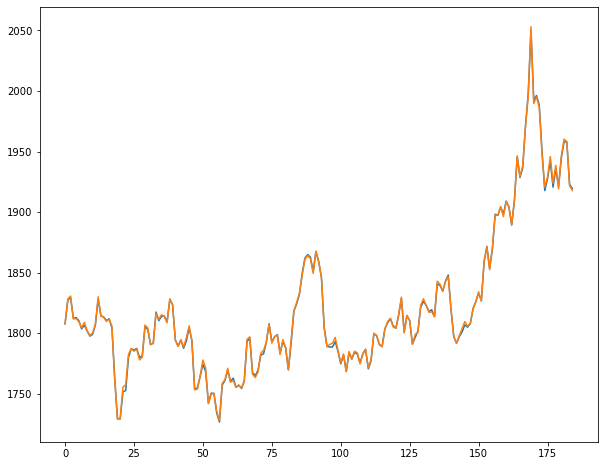

In [275]:
# Plotting out predictions

plt.figure(figsize = (10,8))
plt.plot(sarima_order_book_df['initial_price'])
plt.plot(sarima_order_book_df['pred_price'])

We can see that though it did not ahcieve profitability, our sarima model is decent in predicting 1 time step ahead.